# VideoMAEv2 model availables

### Pre-train

| Model | Config | Dataset | 
| :---: | :----  | :-----: | 
| ViT-giant | vit_g_hybrid_pt_1200e | UnlabeledHybrid | 

### Fine-tune
| Model | Config | Dataset | Pre-train | Post-pre-train |
| :---: | :----  | :-----: | :-------: | :------------: |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_ft | K710 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k400_ft | K400 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k400_ft | K400 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k600_ft | K600 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_ssv2_ft | SSv2 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_ucf101_ft | UCF101 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_hmdb51_ft | HMDB51 | UnlabeledHybrid | K710 |

### Distillation from giant
|  Model  | Dataset | Teacher Model  |
| :-----: | :-----: | :-----------: |
| ViT-small | K710 | vit_g_hybrid_pt_1200e_k710_ft |
| ViT-base | K710 | vit_g_hybrid_pt_1200e_k710_ft | 

### Model details

|  model  | frame channels | frame sampling | frame size (H,W) | tubelet size | patch size | emb dim | output tensor | mem(GB) |
| :-----: | :-----: | :-----------: | :-----: | :-----: | :-----------: | :-----: | :-----: |:----|
| giant | 3 | 16 | (224,224) | 2 | (14,14) | 1408 | [8,16,16,1408] | 4.0 |
| base | 3 | 16 | (224,224) | 2 | (16,16) | 768 | [8,14,14,768] | 0.4|
| small | 3 | 16 | (224,224) | 2 | (16,16) | 384 | [8,14,14,1408] | 0.09|
 


CASE 1
flow -> [batch_video,nr_windows=8,(8,14,14,768)] => 
    => spatial mean reduction =>
    =>[batch_video,nr_windows=8,(8,1,1,768)] => 
    => RESHAPE =>
    => [batch_video,nr_windows=8,(8*1*1*768)] =>
    => 2 GRU((6144,512)|dropout(0.5)|(512,512)) + linear proj (512,1) =>
    => [batch_video,1]

CASE 2
flow -> [batch_video,nr_windows=8,(8,14,14,768)] => 
    => spatial mean reduction =>
    =>[batch_video,nr_windows=8,(8,1,1,768)] => 
    => RESHAPE =>
    => [batch_video,nr_windows=8*8,(1*1*768)] =>
    => 2 GRU((768,512)|drop_out(0.3)|(512,512)) + linear proj (512,1) =>
    => [batch_video,1]
    


# Code (w/ lib) 

Add sanity check when init to see if folders and custom methods are created

Kernel: RBF that can handle non-linear pattern
C: Low to avoid overfit
eps:  high values lead to a simpler model but potentially less precise predictions
      low values require tighter predictions, which can make the model more complex

WHAT I HAVE:

CLIPS_REDUCTION values:
  MEAN: 0 (applied in action recognition)
  GRU: lstm (work in progress)

EMBEDDING_REDUCTION values:
  MEAN_TEMPORAL: 1      [keep spatial information]
  MEAN_SPATIAL: (2, 3)  [keep temporal information]
  MEAN_TEMPORAL_SPATIAL: (1, 2, 3) [applied in action recognition]
  GRU: GRU (work in progress)

MODEL_TYPE values:
  VIDEOMAE_v2_S: smaller model
  VIDEOMAE_v2_B: base model
  VIDEOMAE_v2_G_pt_1200e: giant model w/h intermediate fine-tuning
  VIDEOMAE_v2_G_pt_1200e_K710_it_HMDB51_ft: giant model fine-tuned

SAMPLE_FRAME_STRATEGY values:
  UNIFORM: uniform
  SLIDING_WINDOW: sliding_window
  CENTRAL_SAMPLING: central_sampling
  RANDOM_SAMPLING: random_sampling

HEAD
  SVR
____________________________________________________________________________


TESTING SETTINGS GRID_SEARCH
model_type = MODEL_TYPE.VIDEOMAE_v2_B
embedding_reduction = EMBEDDING_REDUCTION.MEAN_TEMPORAL_SPATIAL
clips_reduction = CLIPS_REDUCTION.MEAN
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.UNIFORM

path_labels = os.path.join('partA','starting_point','subsamples_100_400.csv') # 110 samples per class, 400 samples in total
path_dataset = os.path.join('partA','video','video')
k_cross validation = 5 (Stratified K-Fold cross-validator-> The folds are made by preserving the percentage of samples for each class.)

grid_search = {
  'kernel': ['rbf'],
  'C': [0.1, 1, 10],
  'epsilon': [0.1, 1, 10, 100],
}

Form table we have:
  best_estimator ={
    kernel:'rbf',
    'C': [0.1, 1, 10]
    'epsilon':[10, 100]
  }

<div style="overflow-x: auto;">

In [4]:
sizes = [20] * (10 - 1) + [50]

/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/villi/miniconda3/envs/videoMaev2_project/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/villi/Desktop/PainAssessmentVideo/VideoMAEv2/models/modeling_finetune.py:459: UserWarning: Overwriting vit_small_patch16_224 in registry with VideoMAEv2.models.modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
/home/v

TSNE_X.shape: torch.Size([40, 8, 1, 1, 768])
Using CPU
Start t-SNE computation...
axis_dict {'min_x': -10.367175346788676, 'min_y': -7.968952263685677, 'max_x': 11.1126350284811, 'max_y': 7.524075786248868}
sizes: None
X_tsne[idx,0].shape: (20,)
X_tsne[idx,1].shape: (20,)
sizes: None
X_tsne[idx,0].shape: (20,)
X_tsne[idx,1].shape: (20,)
tsne_Results/tsne_plot_16_clip/sliding_16_subjects_1__clips_2__classes_1_clip.png
Plot saved to tsne_Results/tsne_plot_16_clip.png
1
sizes: [200]
X_tsne[idx,0].shape: (1,)
X_tsne[idx,1].shape: (1,)
tsne_Results/video/1_clip.png
Plot saved to tsne_Results/video.png
2
sizes: [200]
X_tsne[idx,0].shape: (1,)
X_tsne[idx,1].shape: (1,)
sizes: [200]
X_tsne[idx,0].shape: (1,)
X_tsne[idx,1].shape: (1,)
tsne_Results/video/2_clip.png
Plot saved to tsne_Results/video.png
3
sizes: [50, 200]
X_tsne[idx,0].shape: (2,)
X_tsne[idx,1].shape: (2,)
sizes: [200]
X_tsne[idx,0].shape: (1,)
X_tsne[idx,1].shape: (1,)
tsne_Results/video/3_clip.png
Plot saved to tsne_Results/vide

/home/villi/Desktop/PainAssessmentVideo/custom/tools.py:649: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 8))


Plot saved to tsne_Results/video.png
23
sizes: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 200]
X_tsne[idx,0].shape: (12,)
X_tsne[idx,1].shape: (12,)
sizes: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 200]
X_tsne[idx,0].shape: (11,)
X_tsne[idx,1].shape: (11,)
tsne_Results/video/23_clip.png
Plot saved to tsne_Results/video.png
24
sizes: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 200]
X_tsne[idx,0].shape: (12,)
X_tsne[idx,1].shape: (12,)
sizes: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 200]
X_tsne[idx,0].shape: (12,)
X_tsne[idx,1].shape: (12,)
tsne_Results/video/24_clip.png
Plot saved to tsne_Results/video.png
25
sizes: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 200]
X_tsne[idx,0].shape: (13,)
X_tsne[idx,1].shape: (13,)
sizes: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 200]
X_tsne[idx,0].shape: (12,)
X_tsne[idx,1].shape: (12,)
tsne_Results/video/25_clip.png
Plot saved to tsne_Results/video.png
26
sizes: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 200]
X_tsne[idx,0].shape:

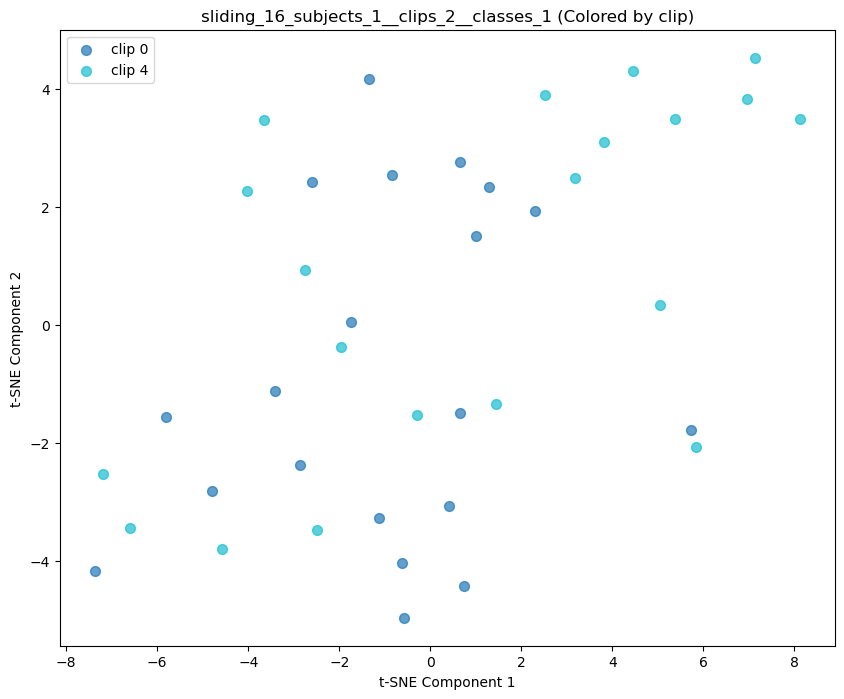

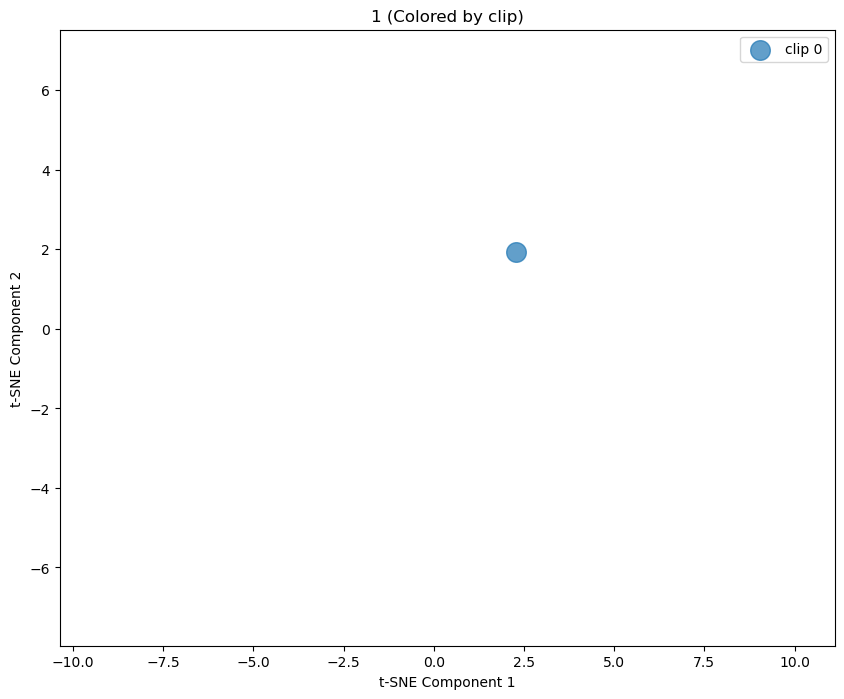

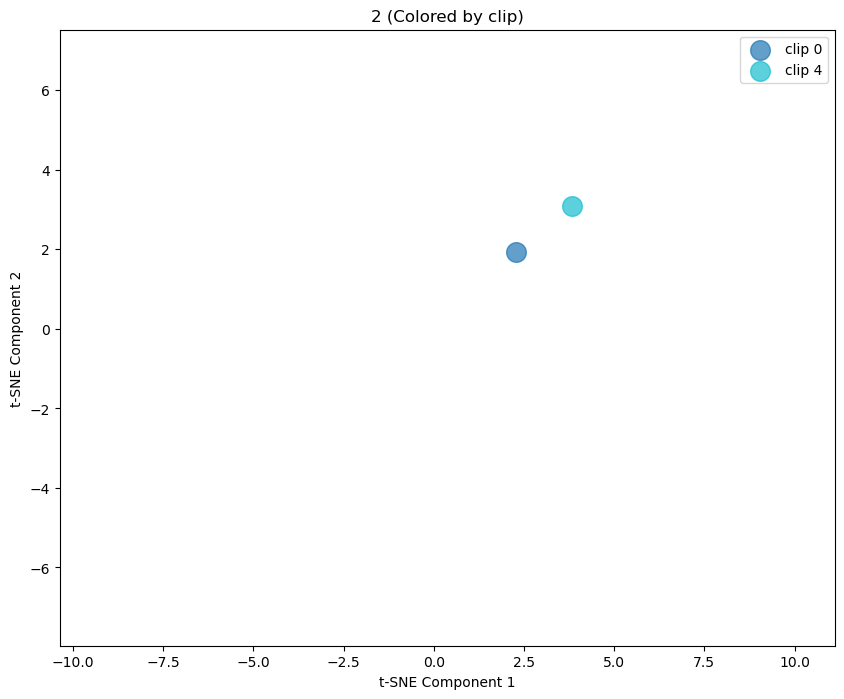

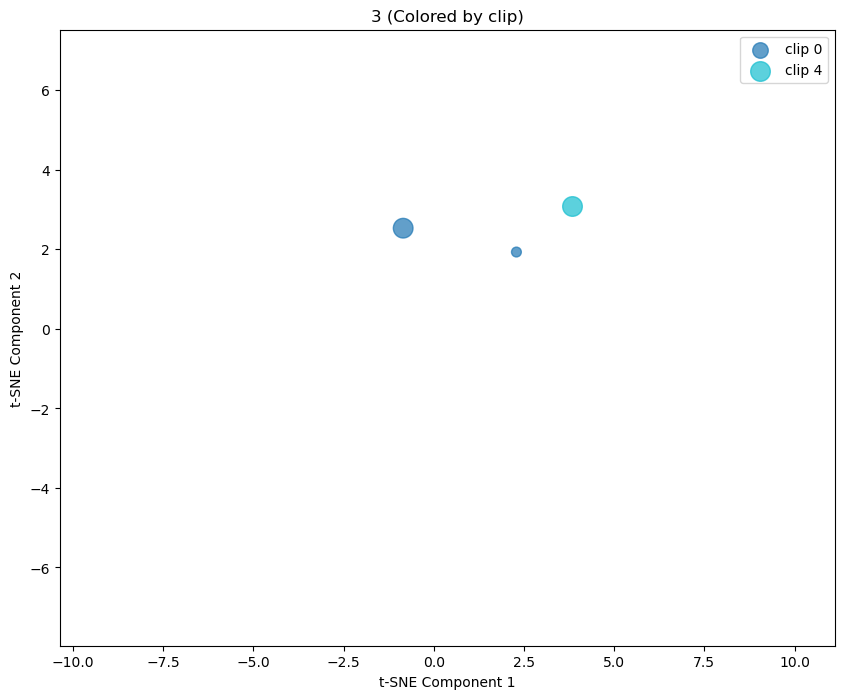

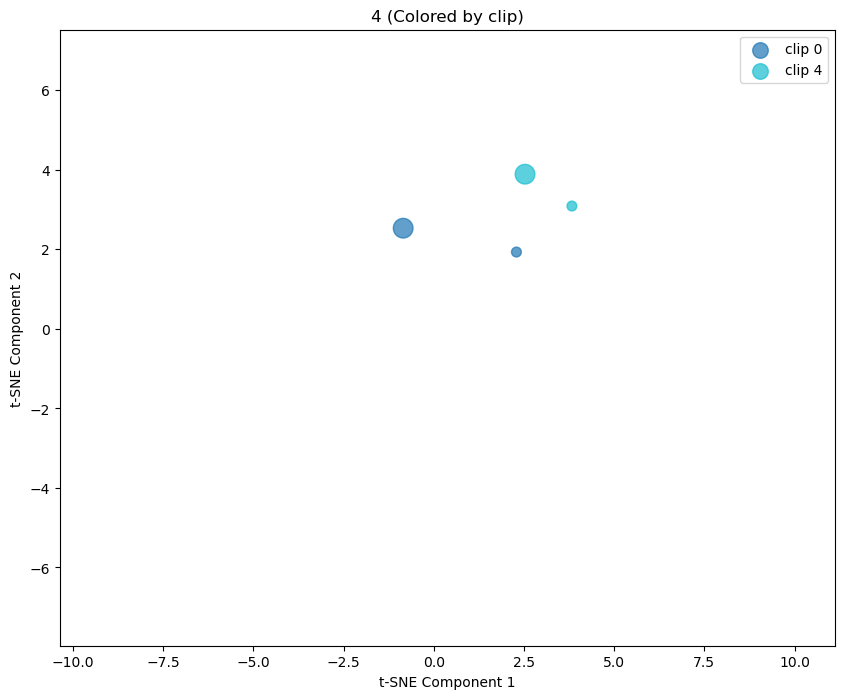

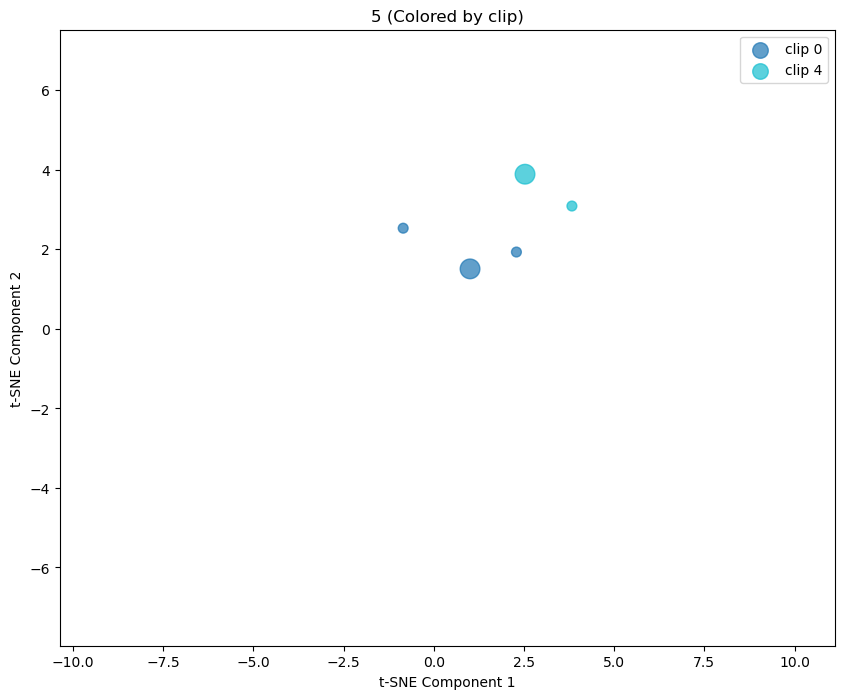

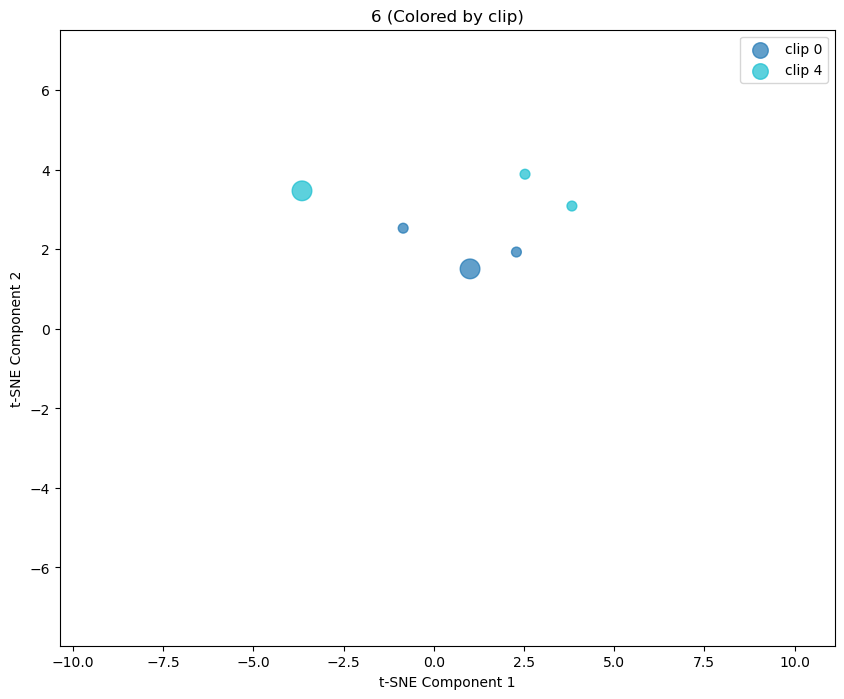

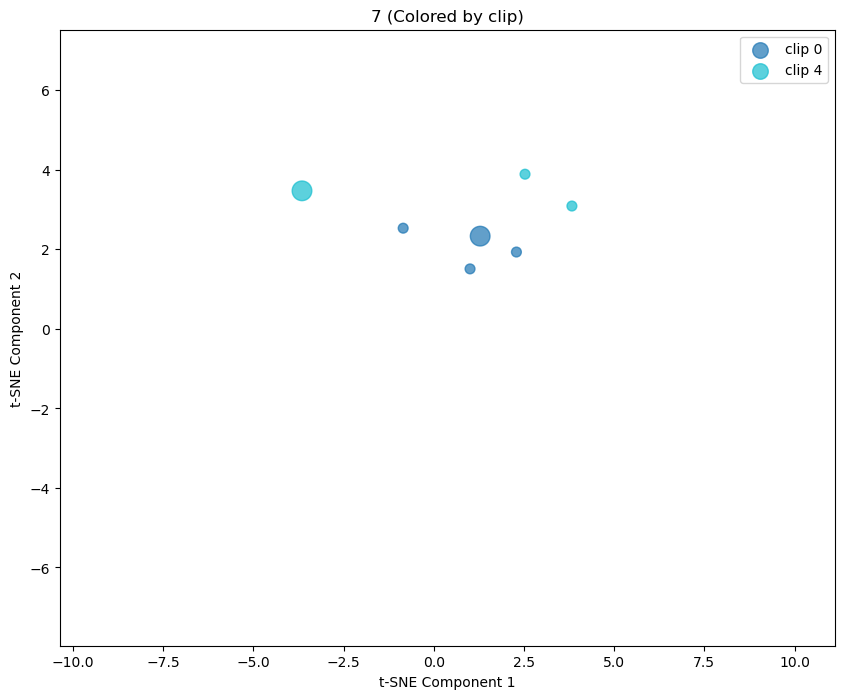

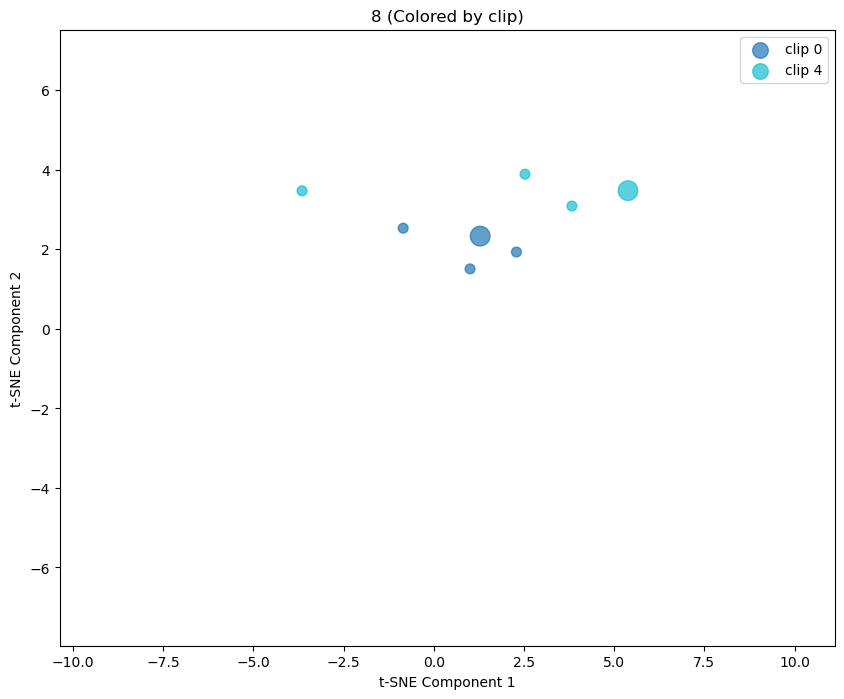

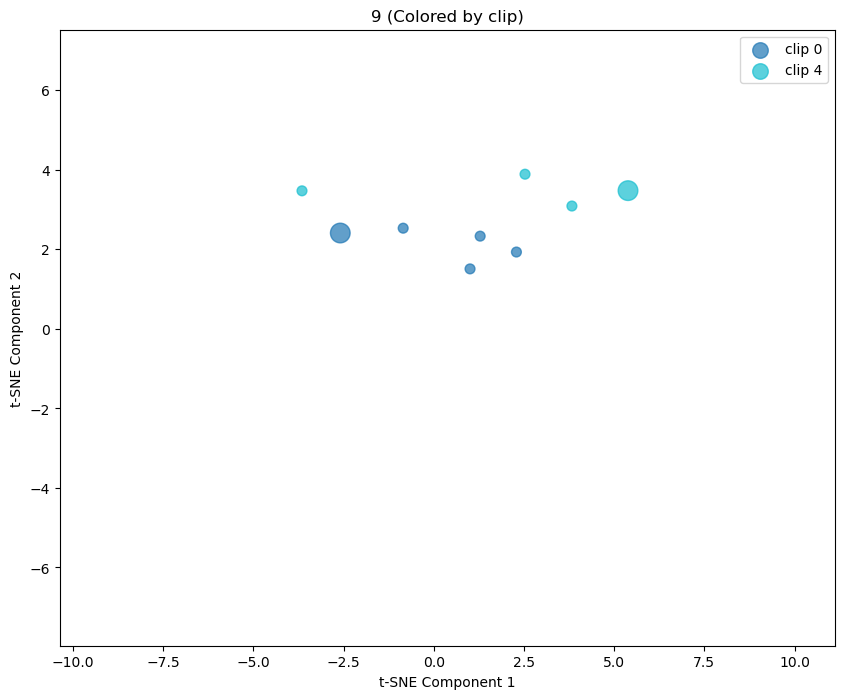

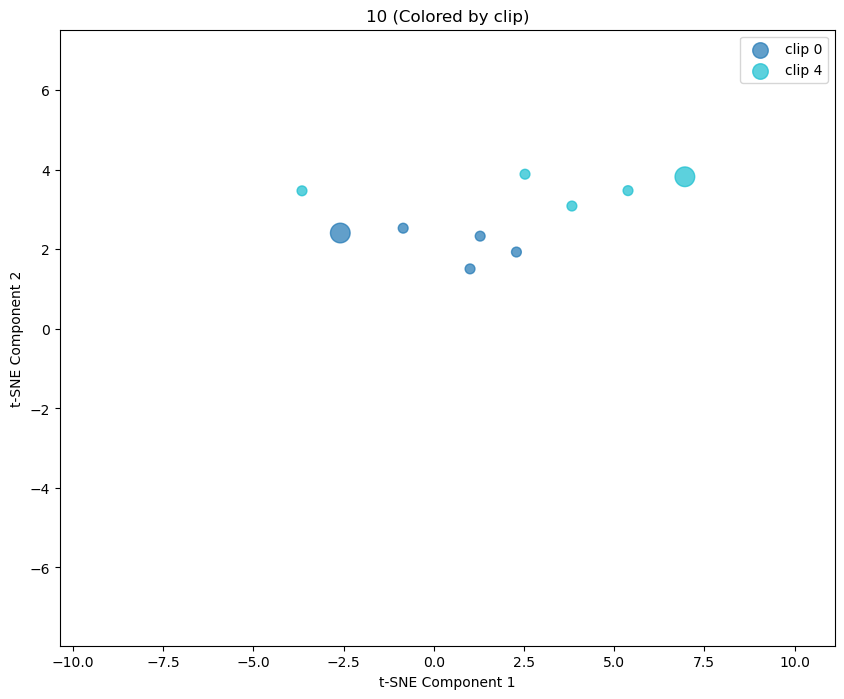

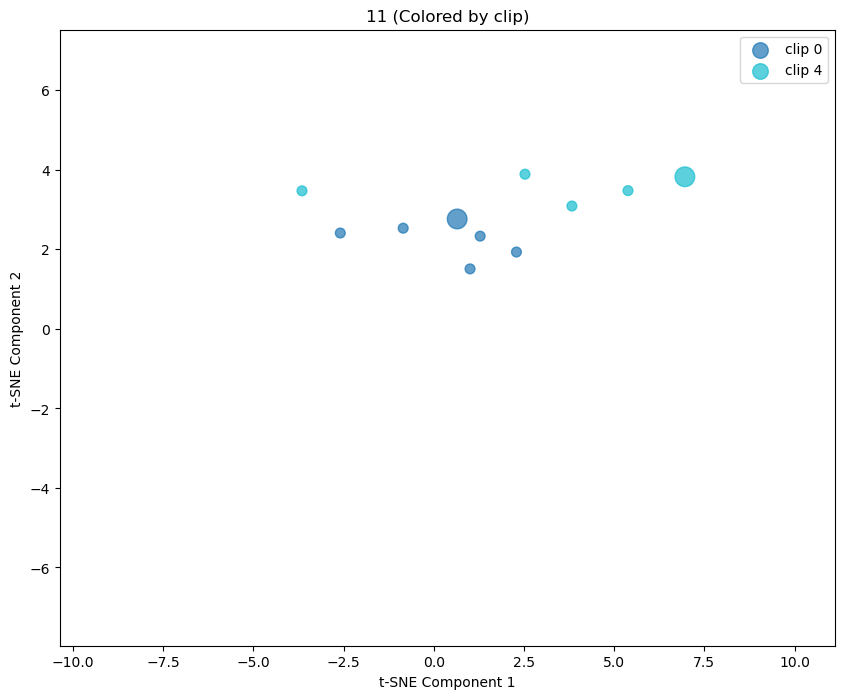

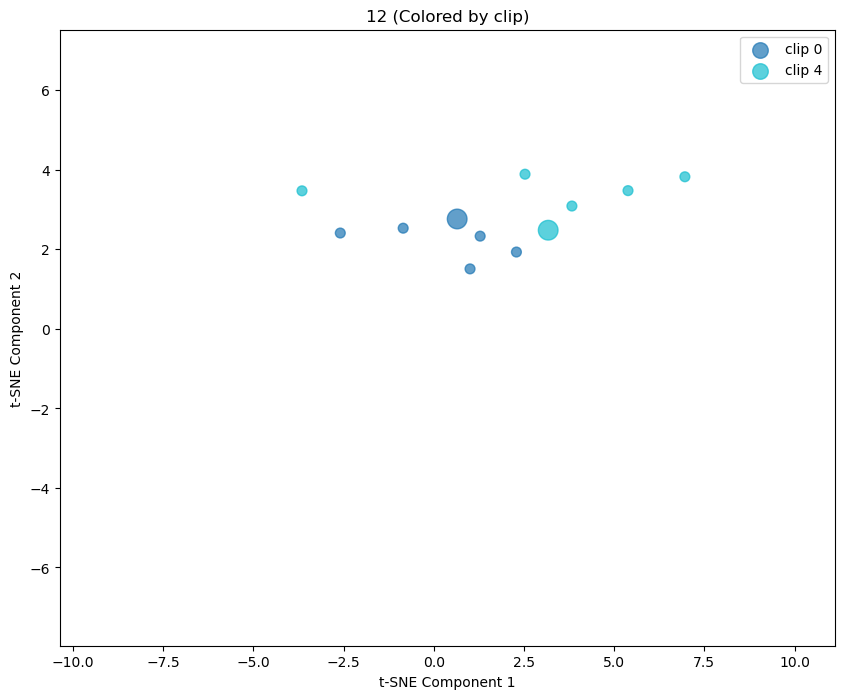

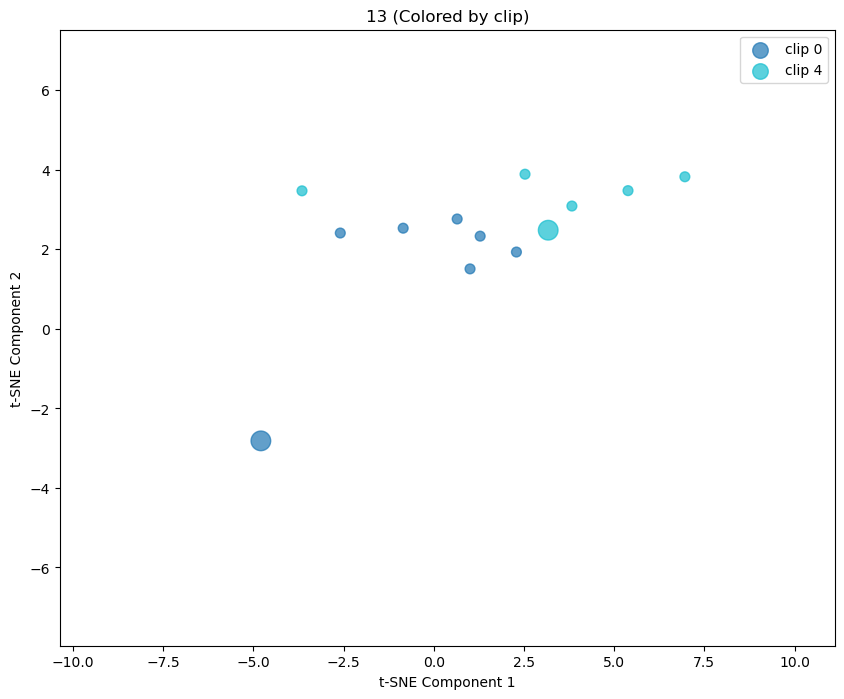

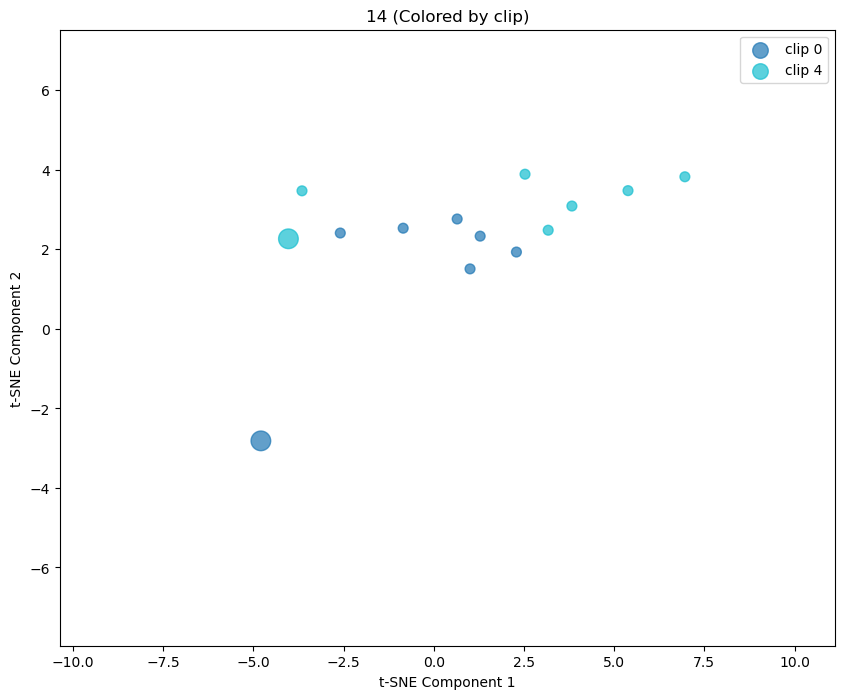

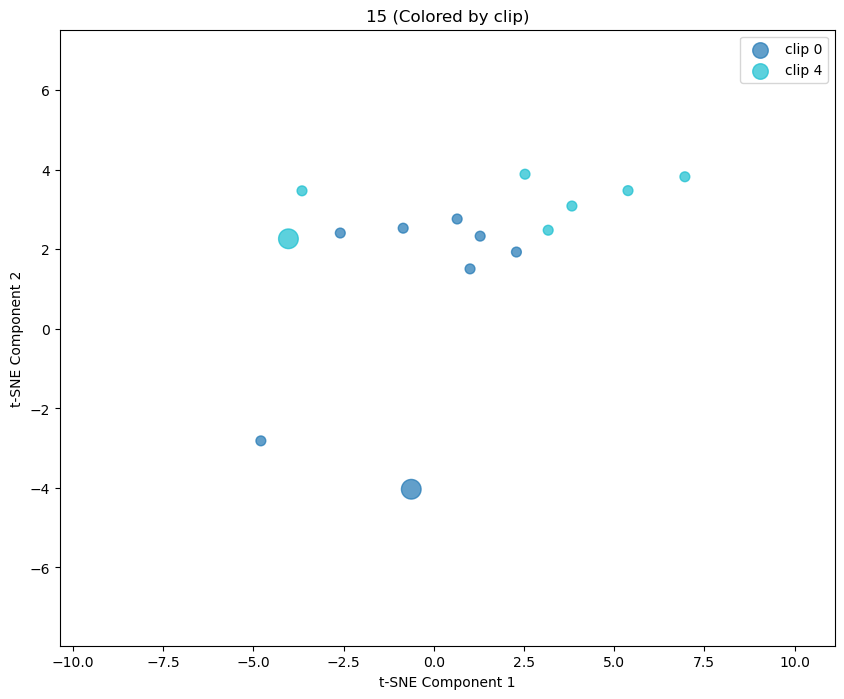

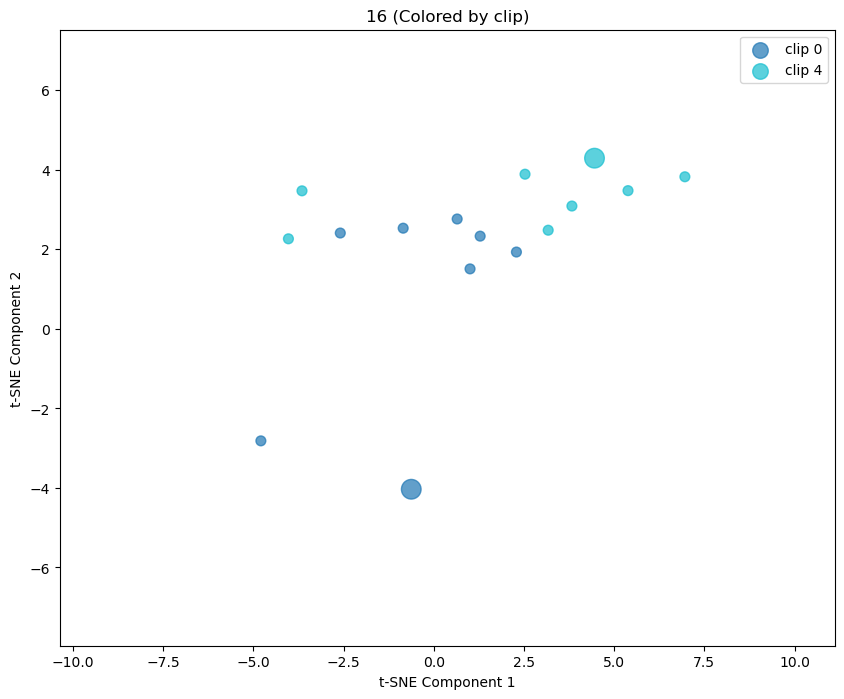

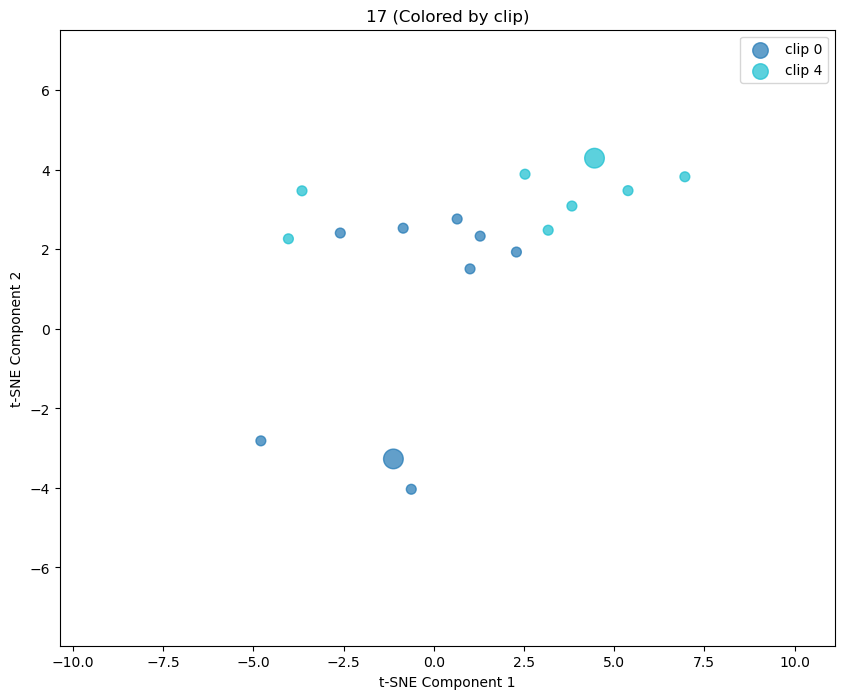

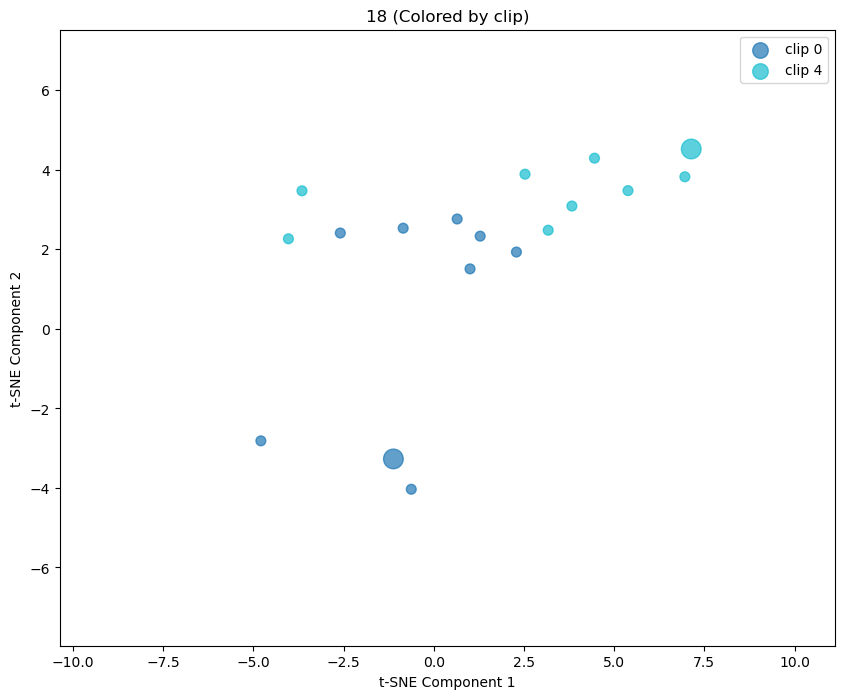

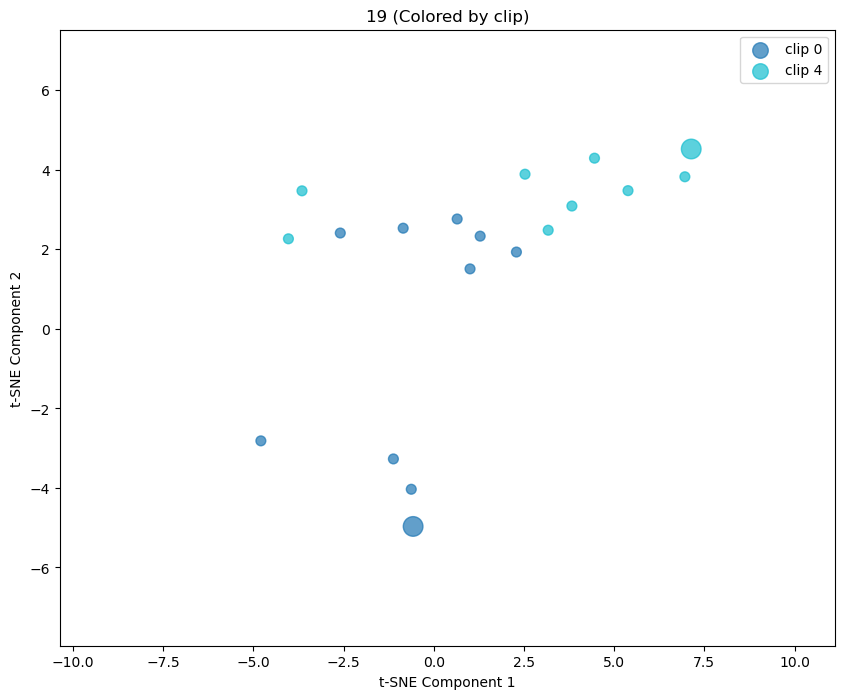

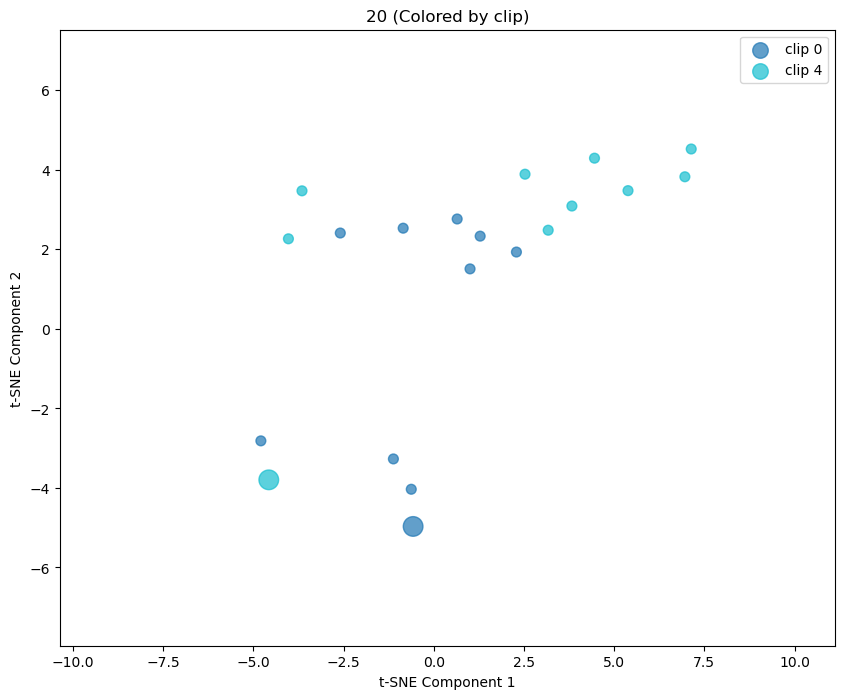

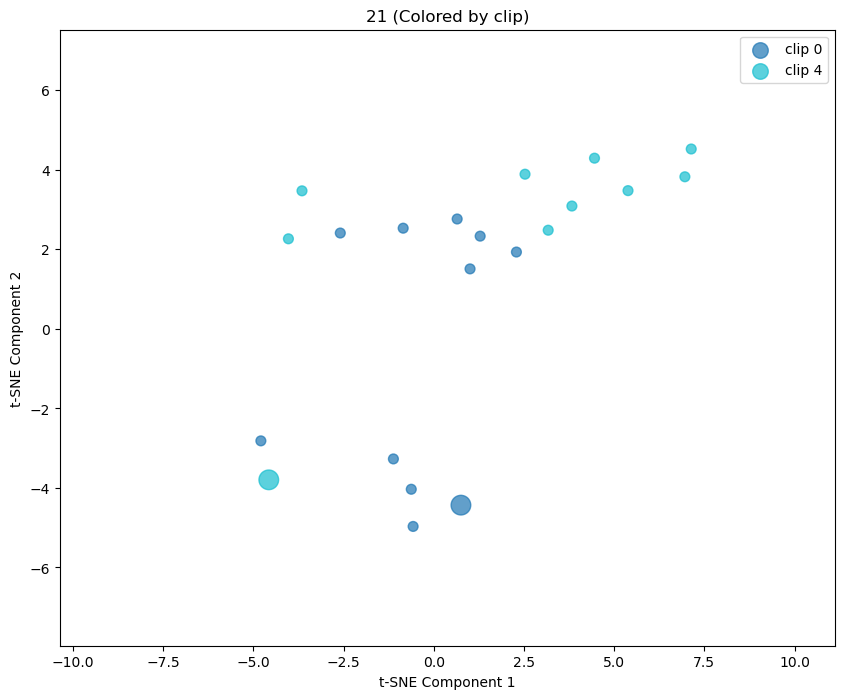

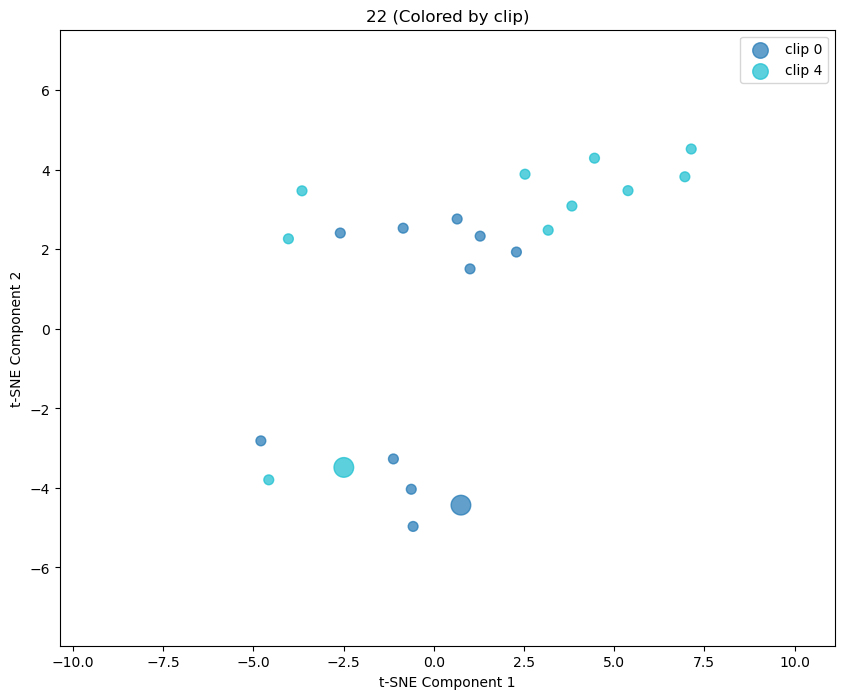

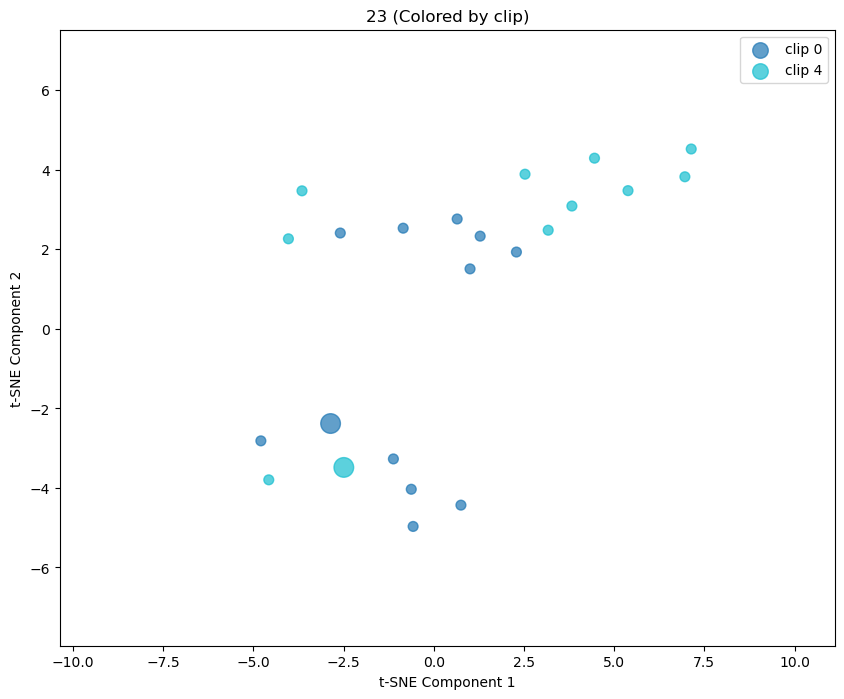

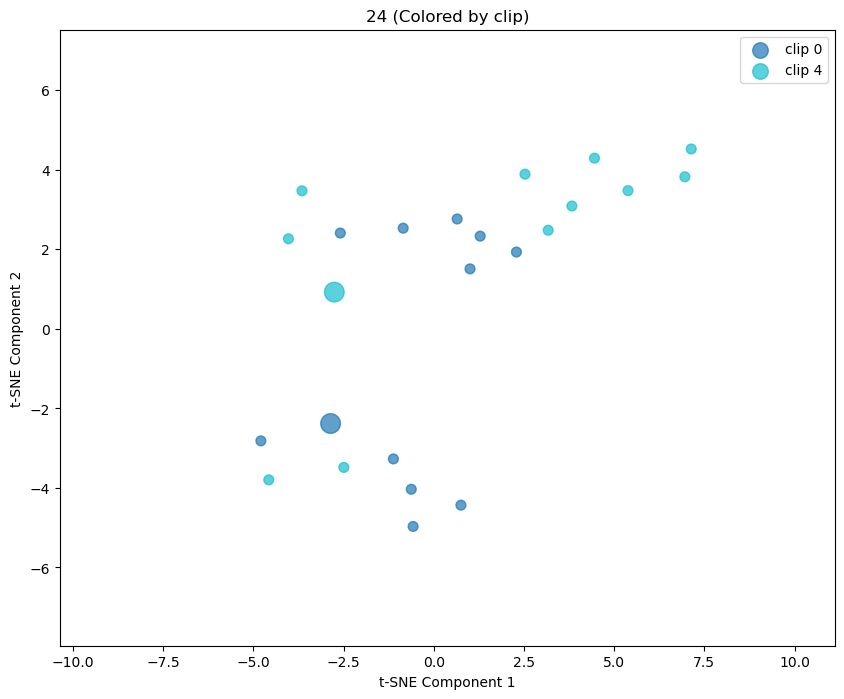

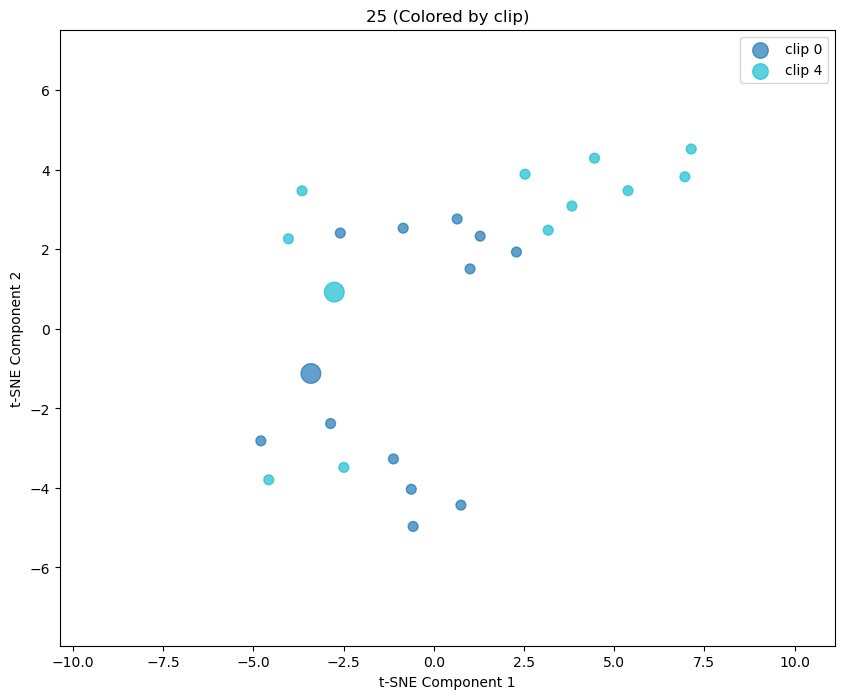

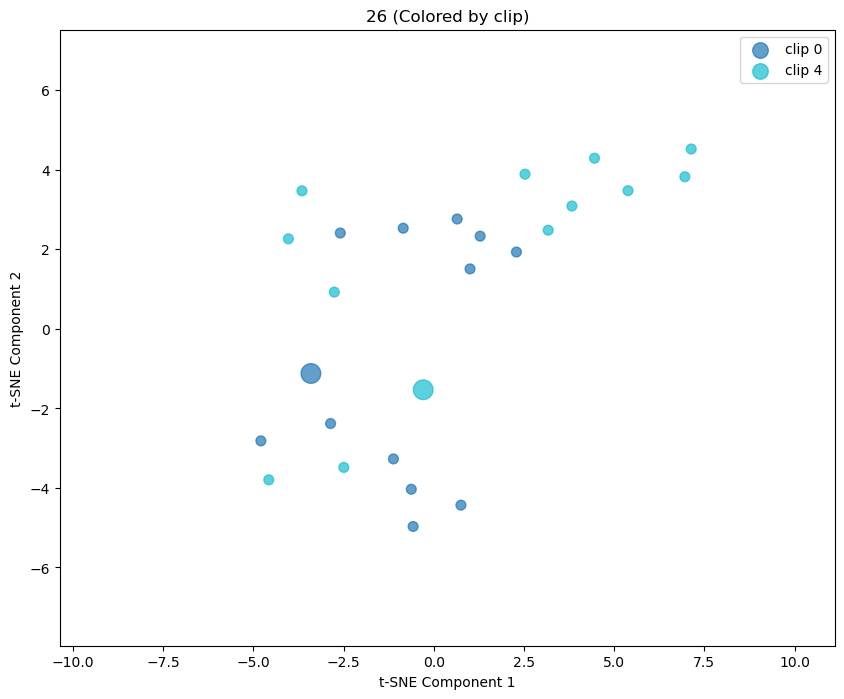

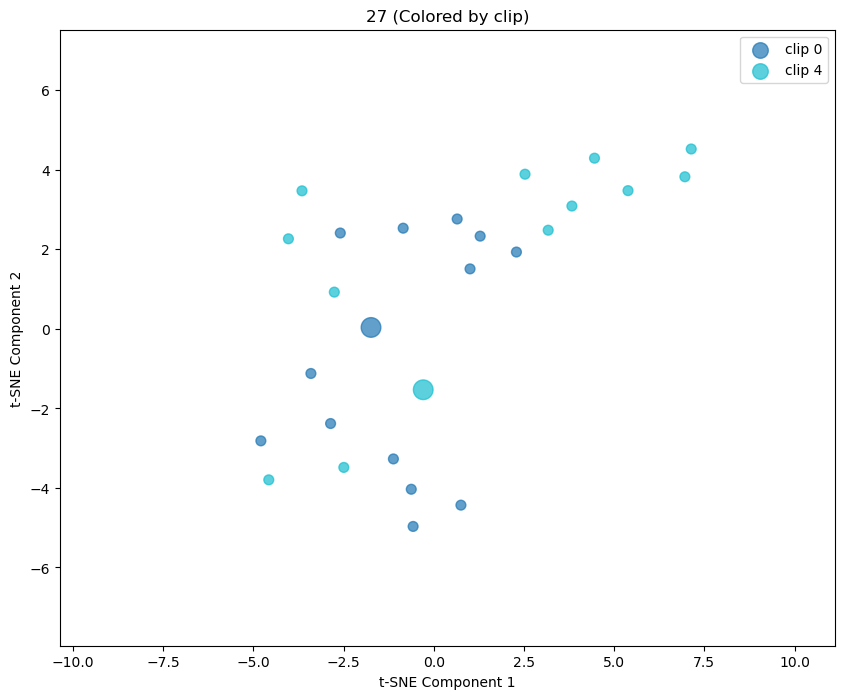

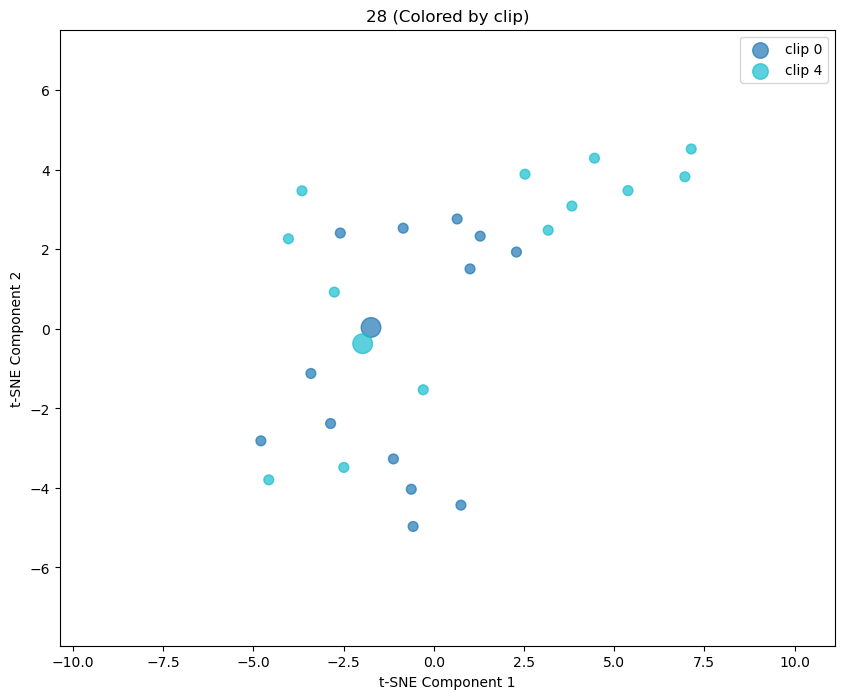

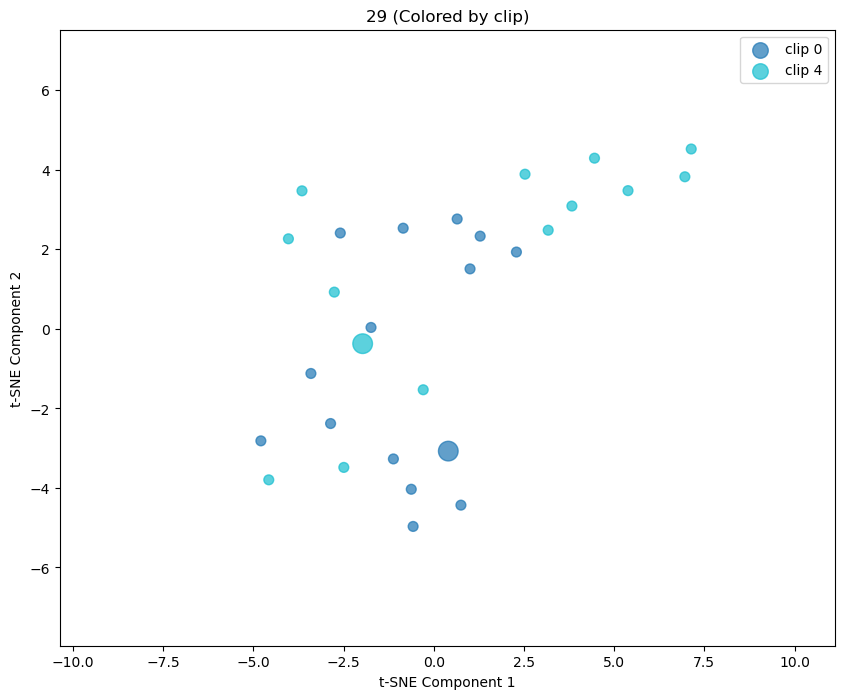

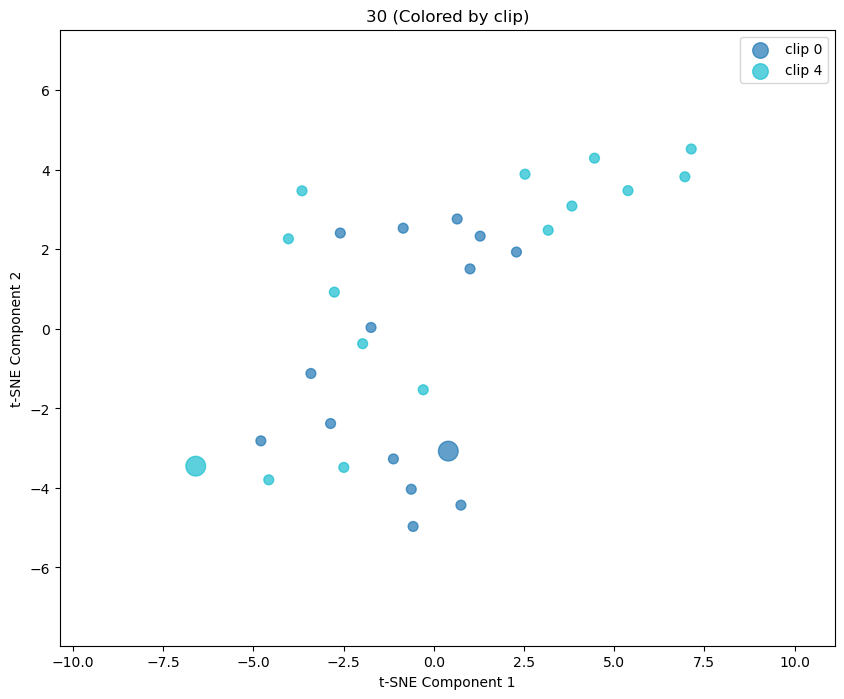

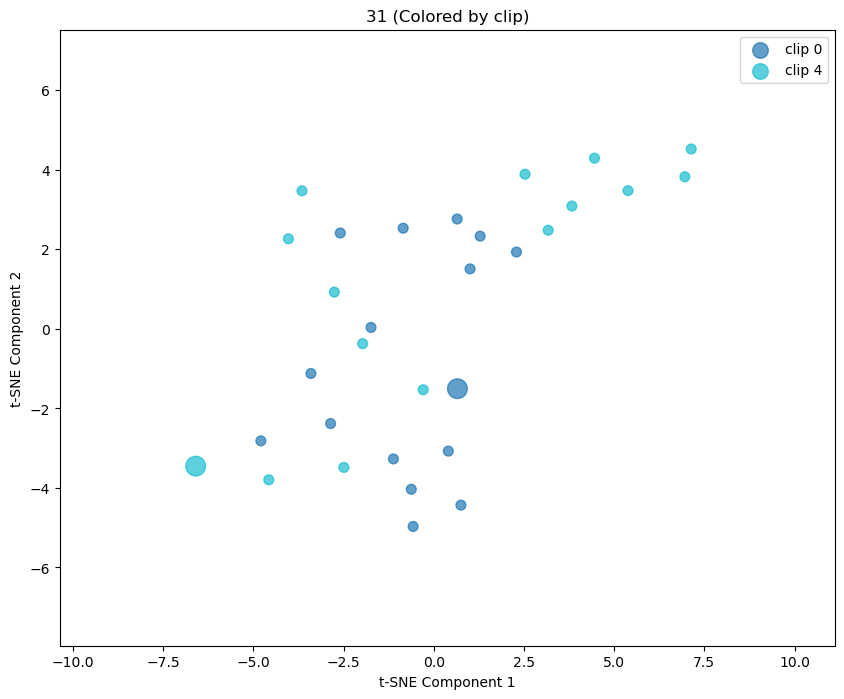

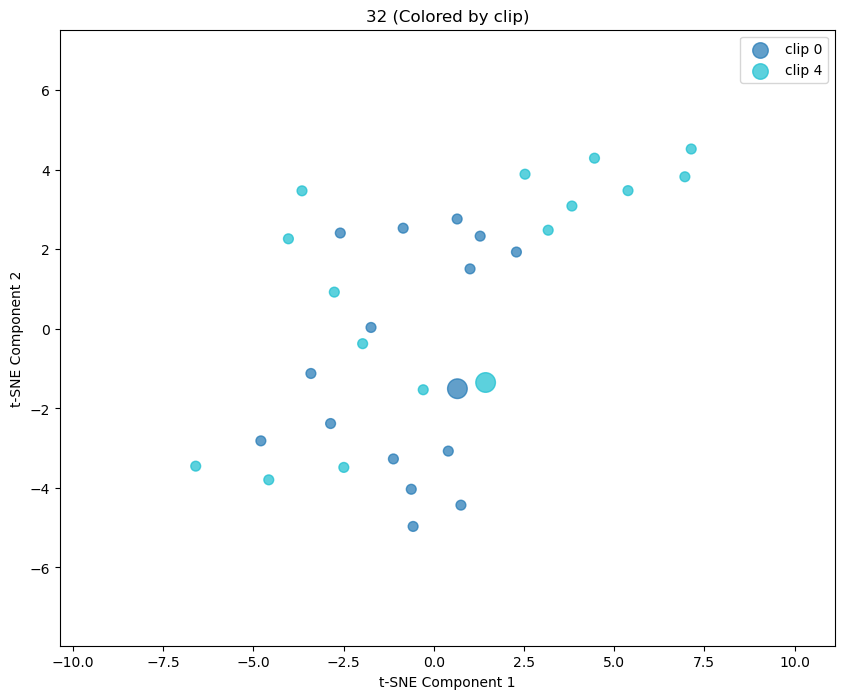

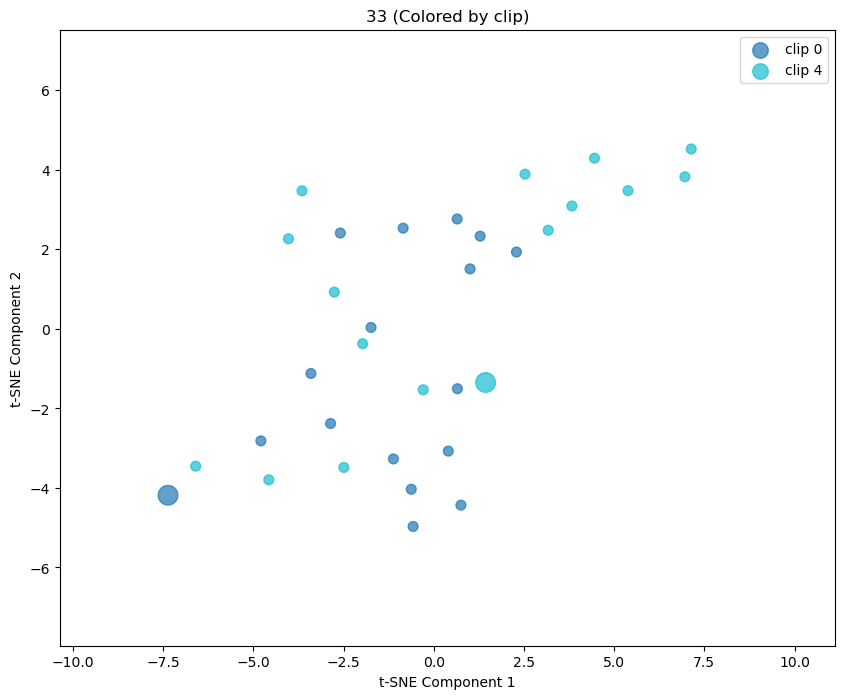

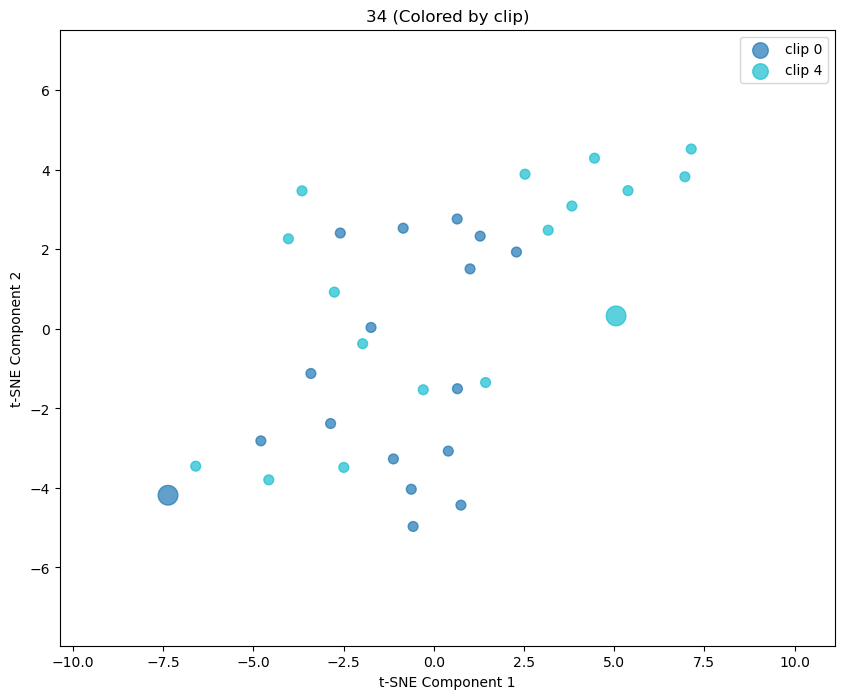

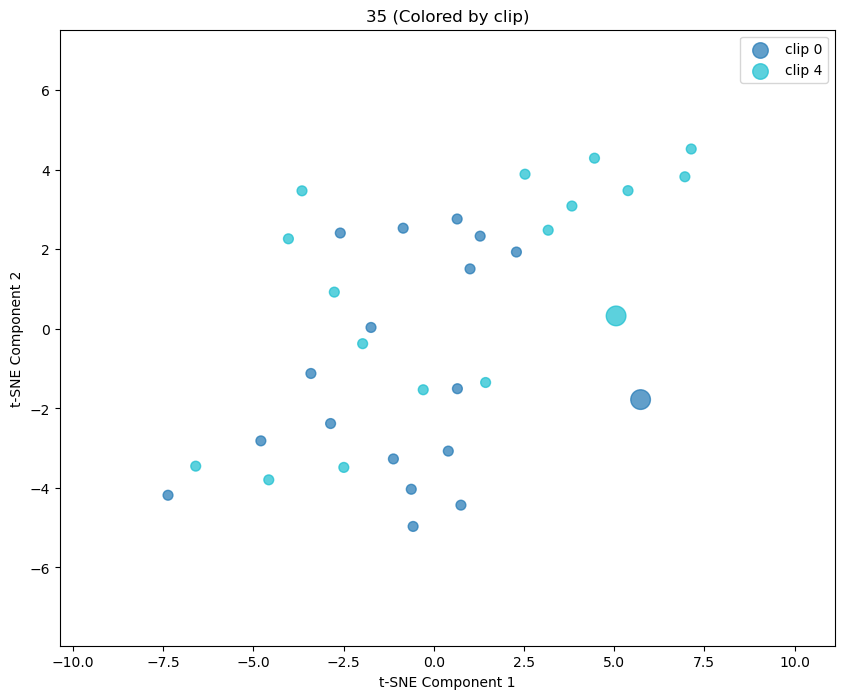

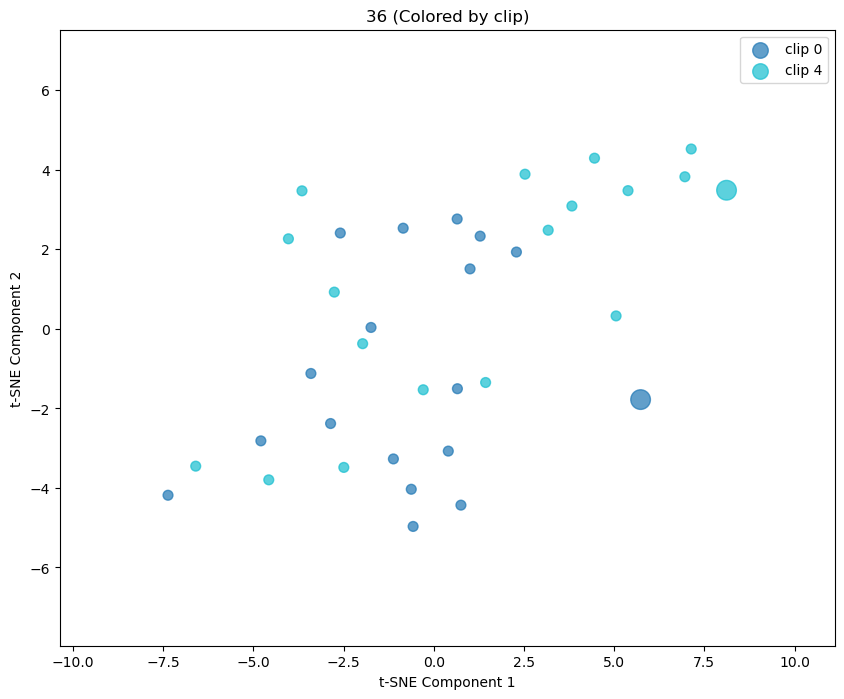

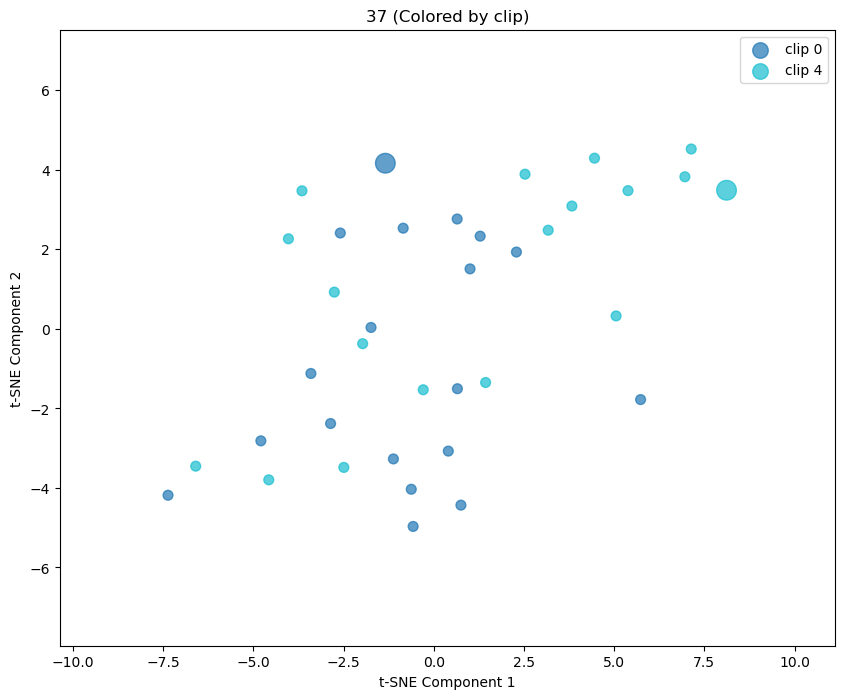

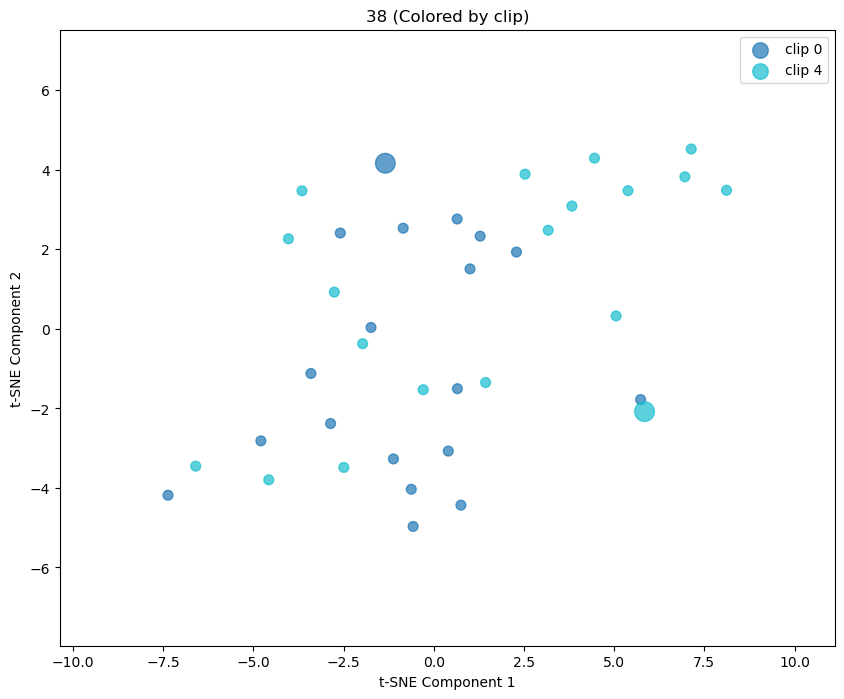

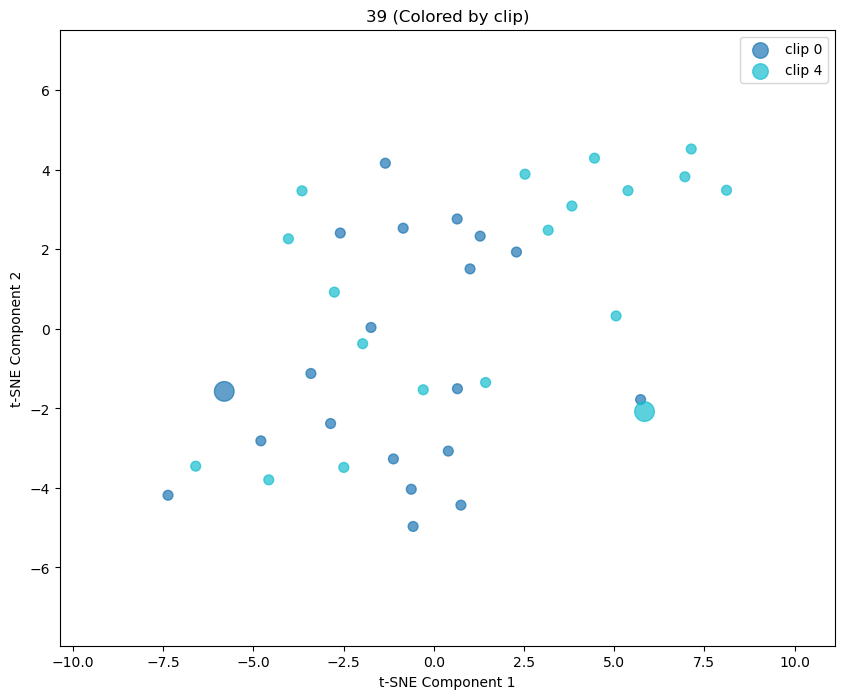

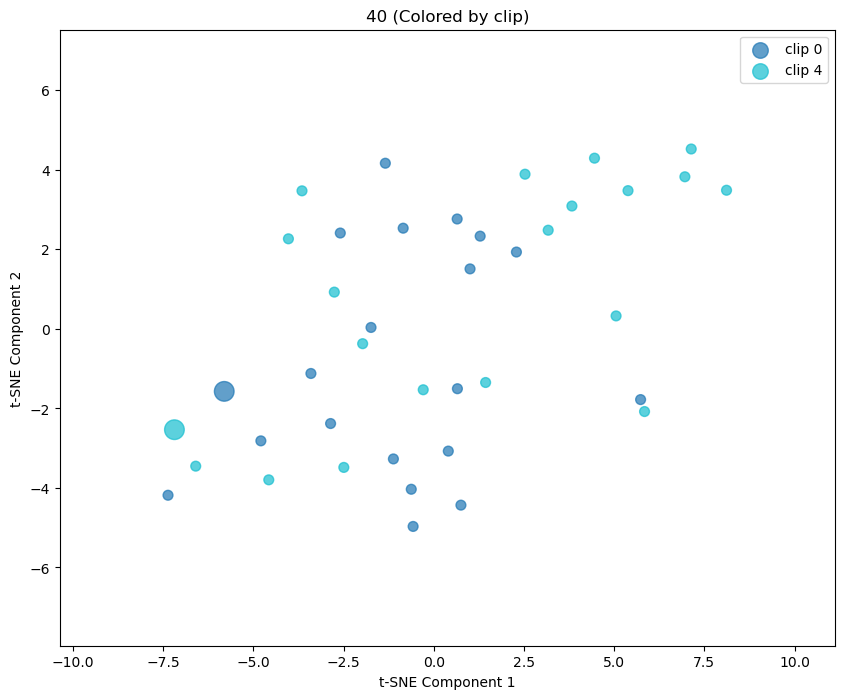

In [1]:
%load_ext autoreload
%autoreload 2
import custom.tools as tools
import custom.scripts as scripts
import os
# OK finish the video clip, start to create plot list_same_clip_positions many people
# try to combine plot and video in one
folder_tsne_results = 'tsne_Results'
folder_path_features = os.path.join('partA','video','features','samples_16')

if not os.path.exists(folder_tsne_results):
    os.makedirs(folder_tsne_results)

subject_id_list = [5]
clip_list = [0,4]
class_list = [4]
sliding_windows =  16
legend_label = 'clip' # can be clip, subject and class    
scripts.plot_and_generate_video(folder_path_features=folder_path_features,
                                folder_path_tsne_results=folder_tsne_results,
                                subject_id_list=subject_id_list,
                                clip_list=clip_list,
                                legend_label=legend_label,
                                class_list=class_list,
                                sliding_windows=sliding_windows)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set path_labels: partA/starting_point/samples.csv
Start training phase the model at history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734094085
 list_splits_idxs [array([   0,    1,    2, ..., 8197, 8198, 8199]), array([ 100,  101,  102, ..., 8297, 8298, 8299]), array([ 200,  201,  202, ..., 8397, 8398, 8399]), array([ 300,  301,  302, ..., 8697, 8698, 8699]), array([ 400,  401,  402, ..., 8597, 8598, 8599])]
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734094085/train_GRU/k0_cross_val/test.csv
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734094085/train_GRU/k0_cross_val/val.csv
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734094085/train_GRU/k0_cross_val/train.csv
training using validation set
Extracting features...
csv_path:history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_173

/home/villi/Desktop/PainAssessmentVideo/custom/tools.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


Plot MAE per subject saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734094085/train_GRU/k2_cross_val/losses/train_mae_per_subject.png.png
Plot MAE per subject saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734094085/train_GRU/k2_cross_val/losses/test_mae_per_subject.png.png
Plot losses saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734094085/train_GRU/k2_cross_val/losses/train_test_loss.png.png
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734094085/train_GRU/k3_cross_val/test.csv
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734094085/train_GRU/k3_cross_val/val.csv
CSV saved to history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734094085/train_GRU/k3_cross_val/train.csv
training using validation set
Extracting features...
csv_path:history_run/VIDEOMAE_v2_S_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1734094085/train_GRU/k3_cross_val/train.cs

KeyboardInterrupt: 

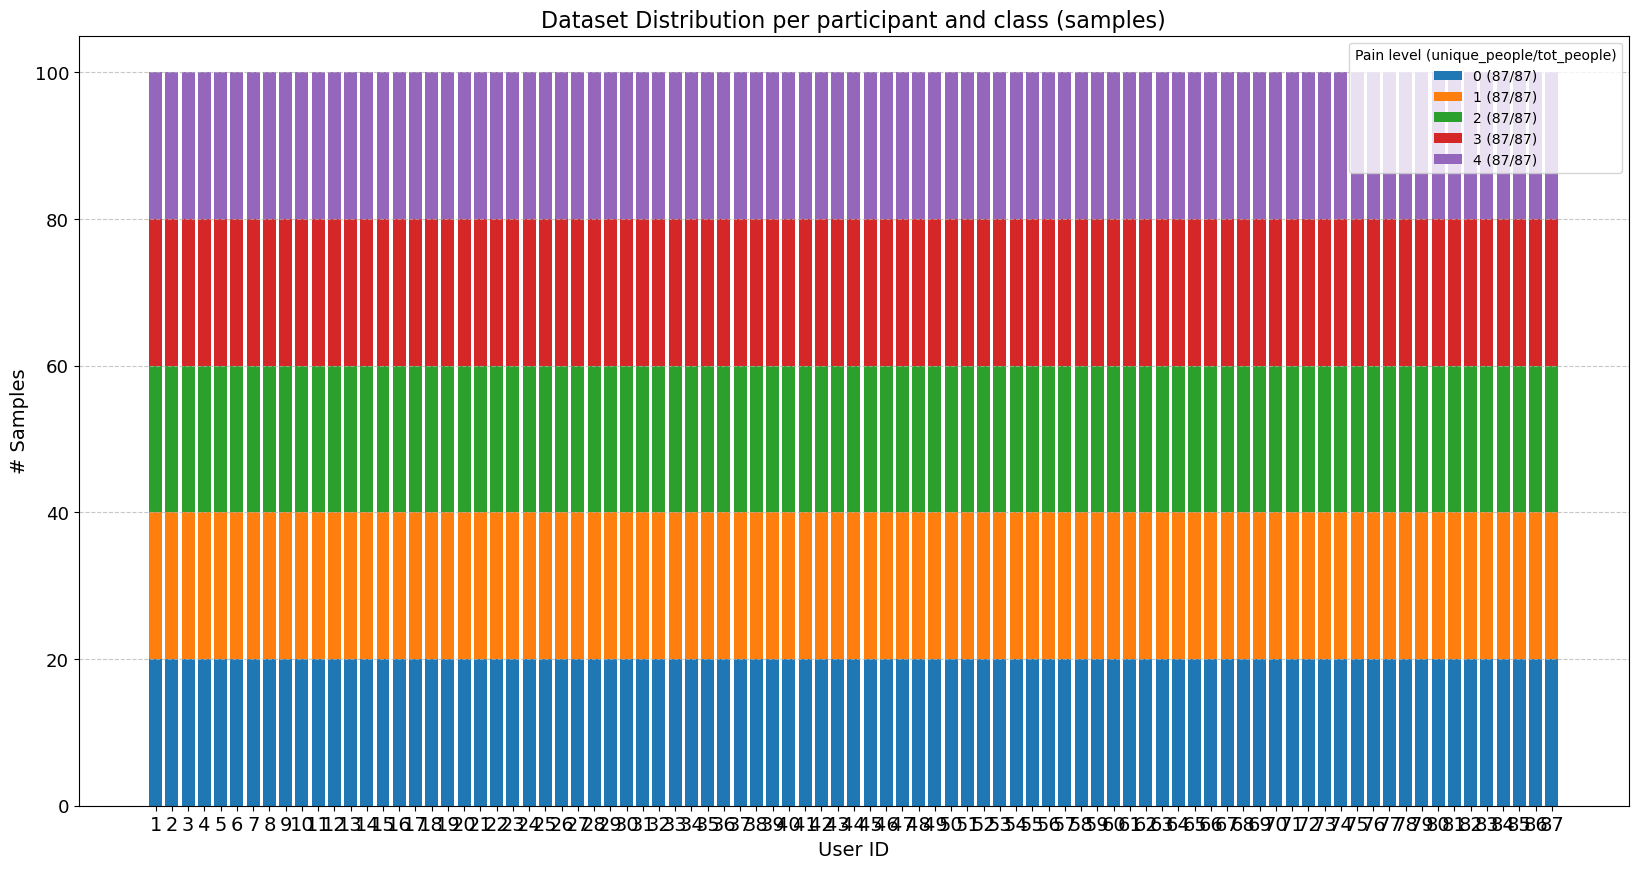

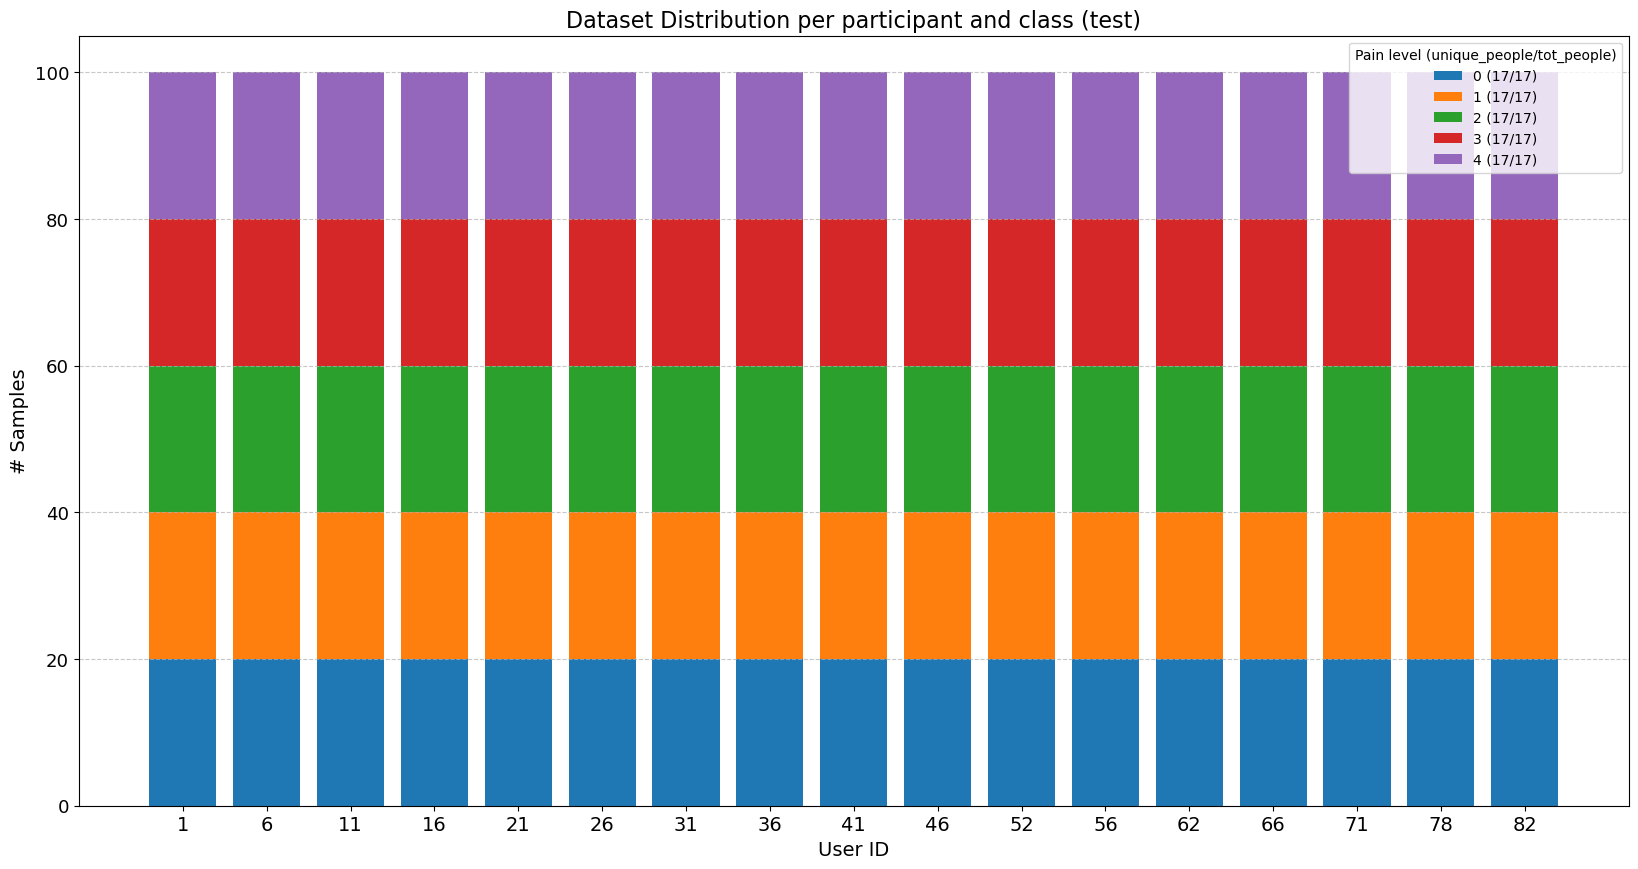

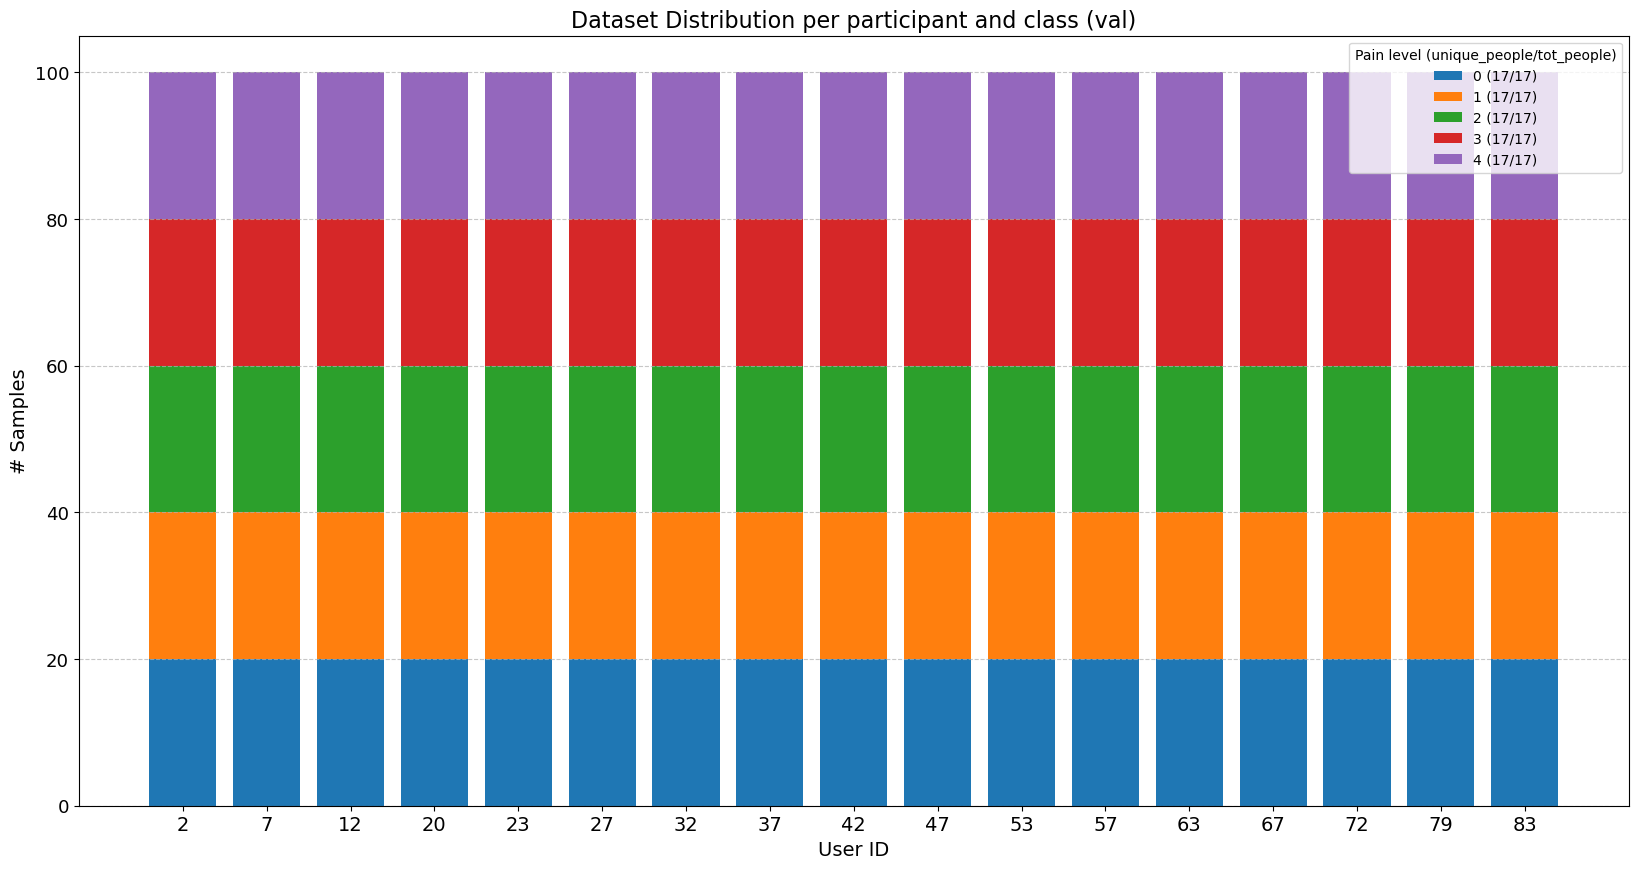

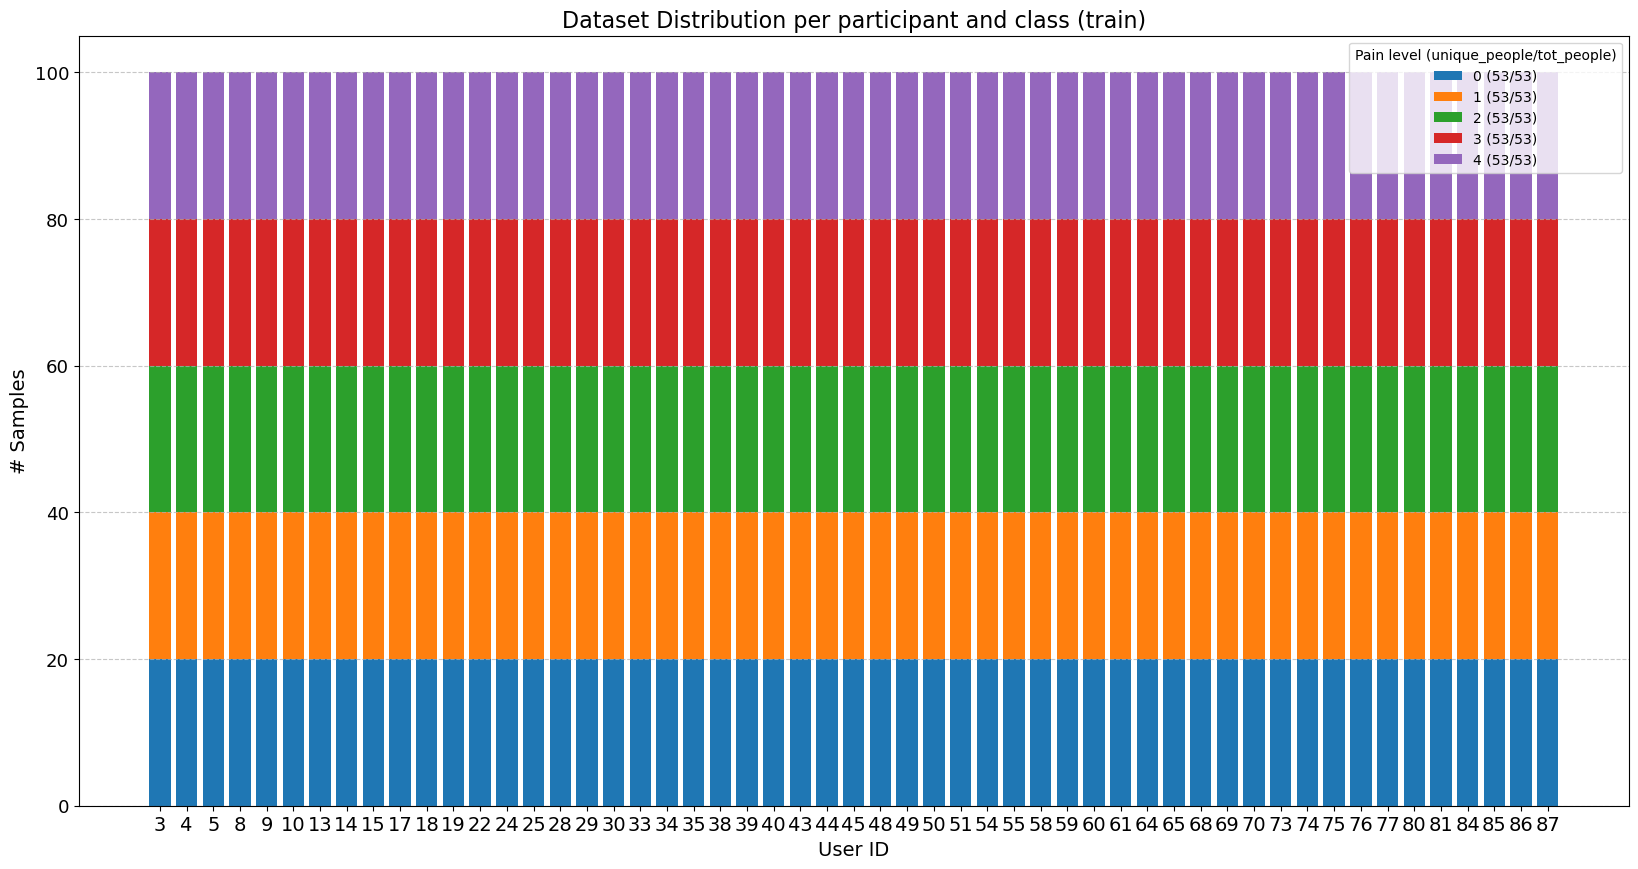

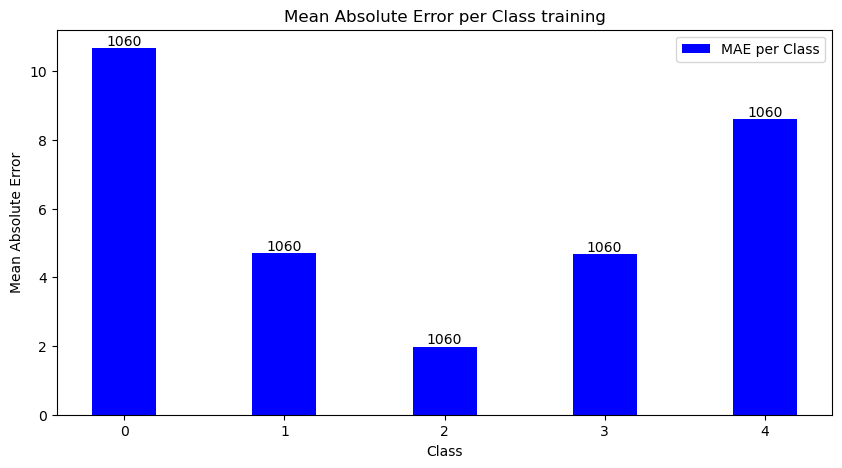

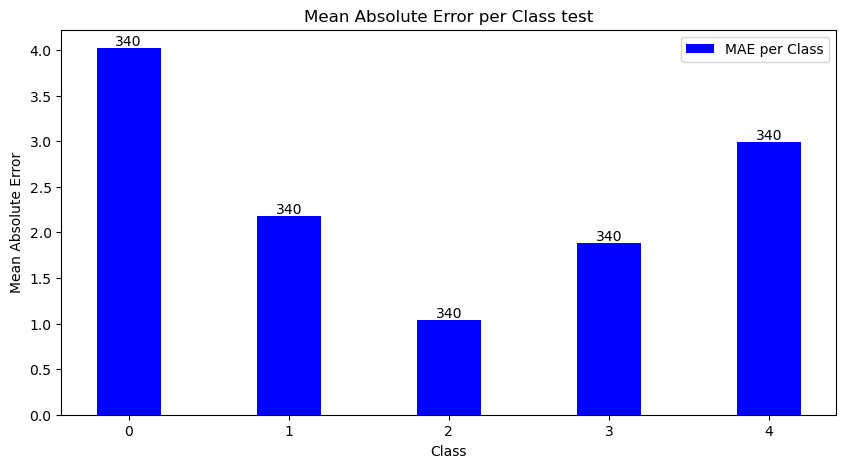

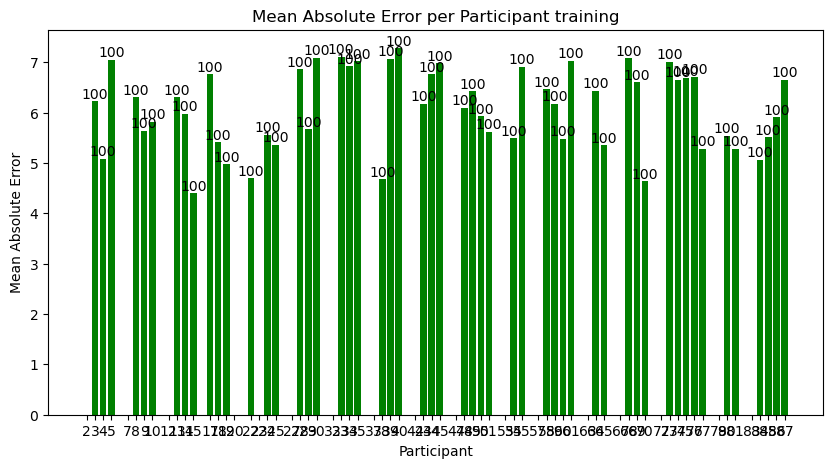

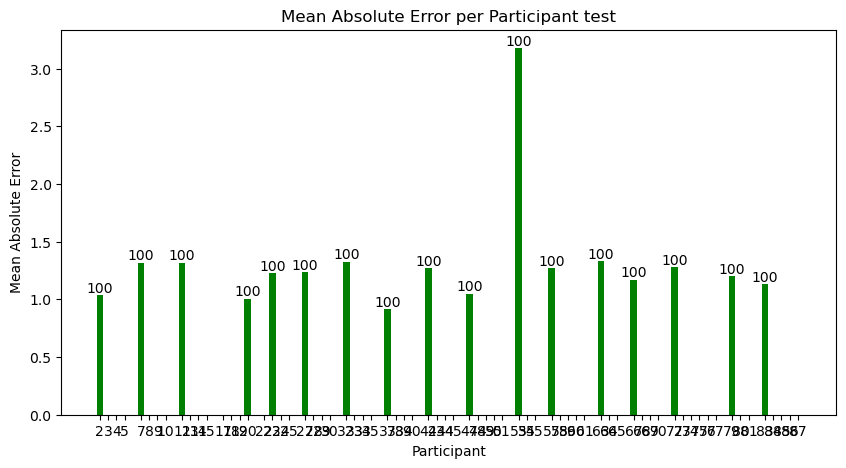

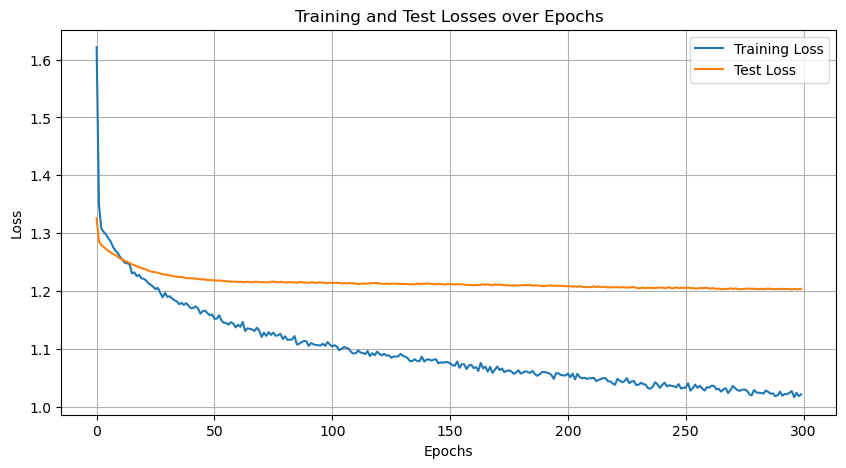

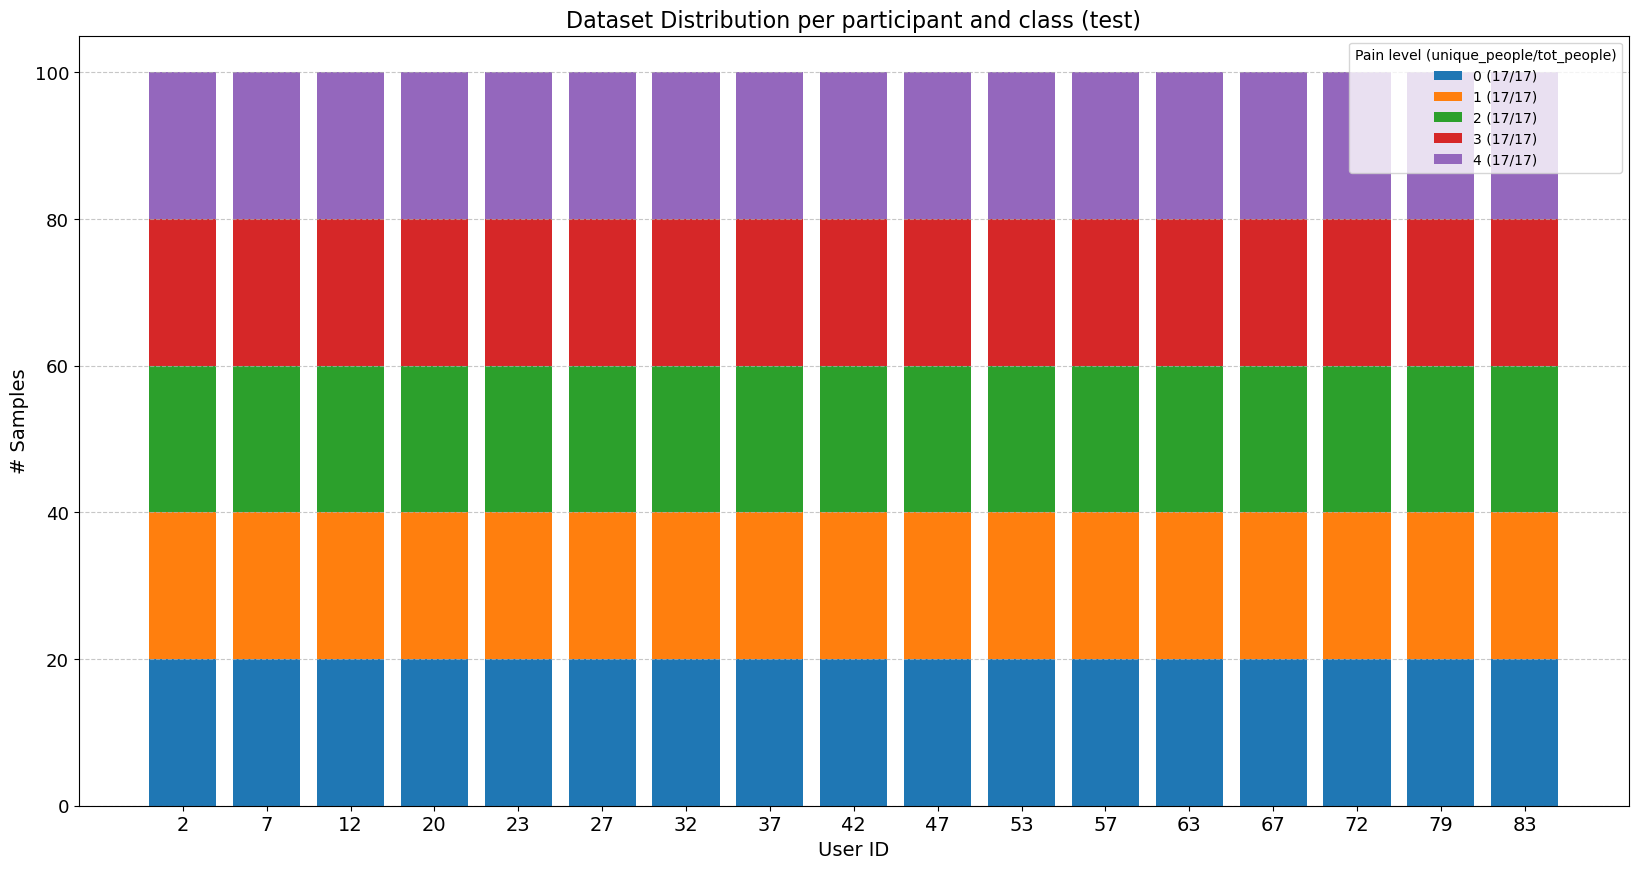

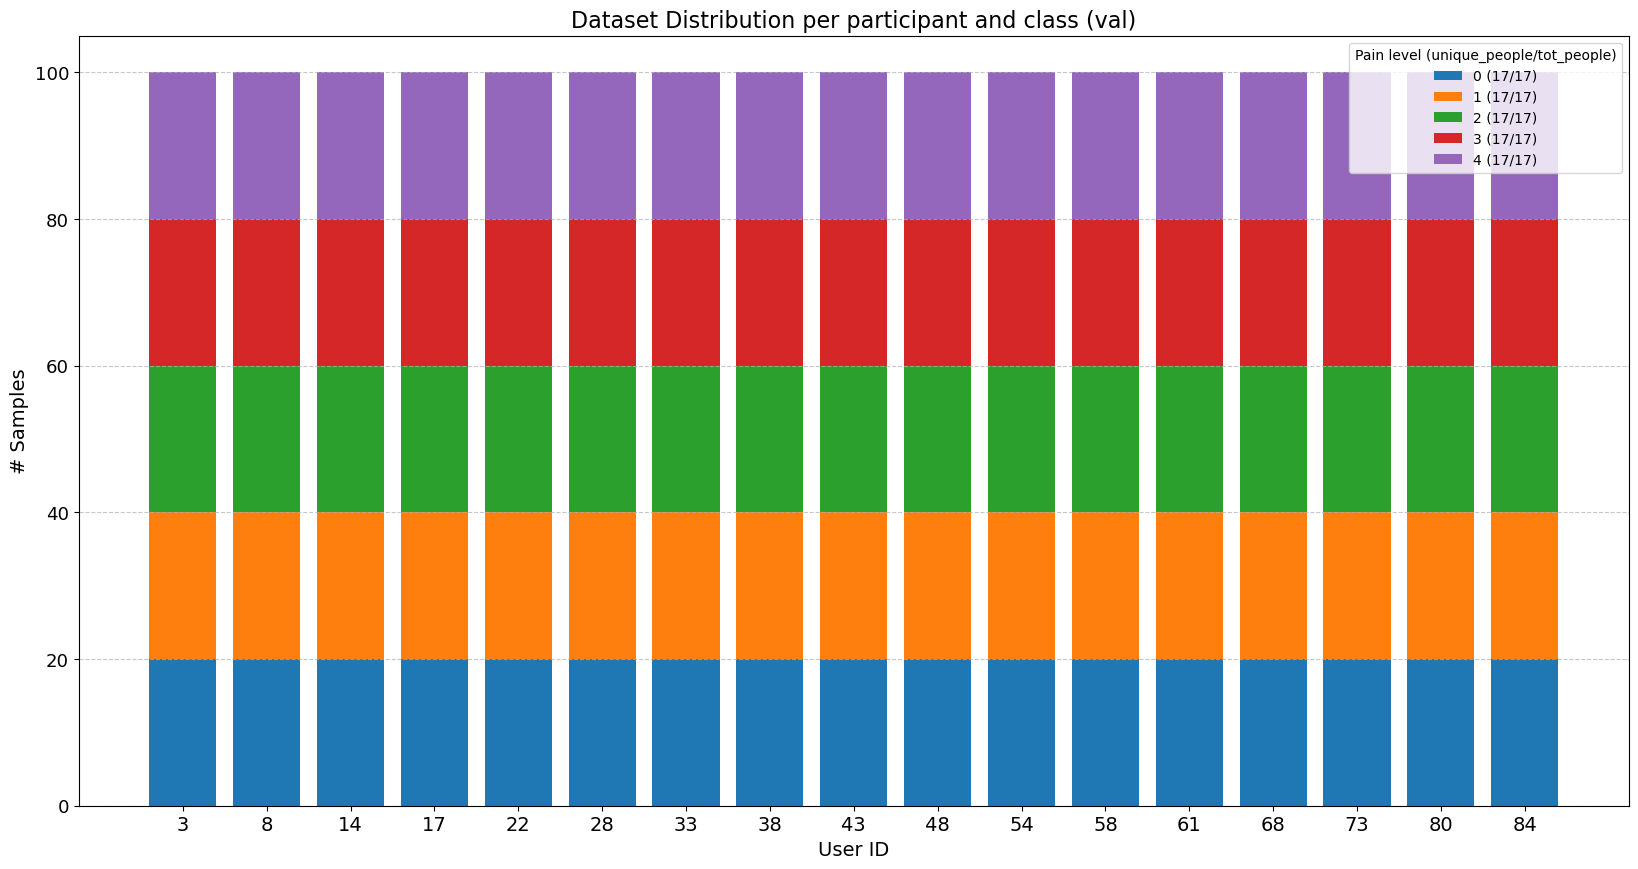

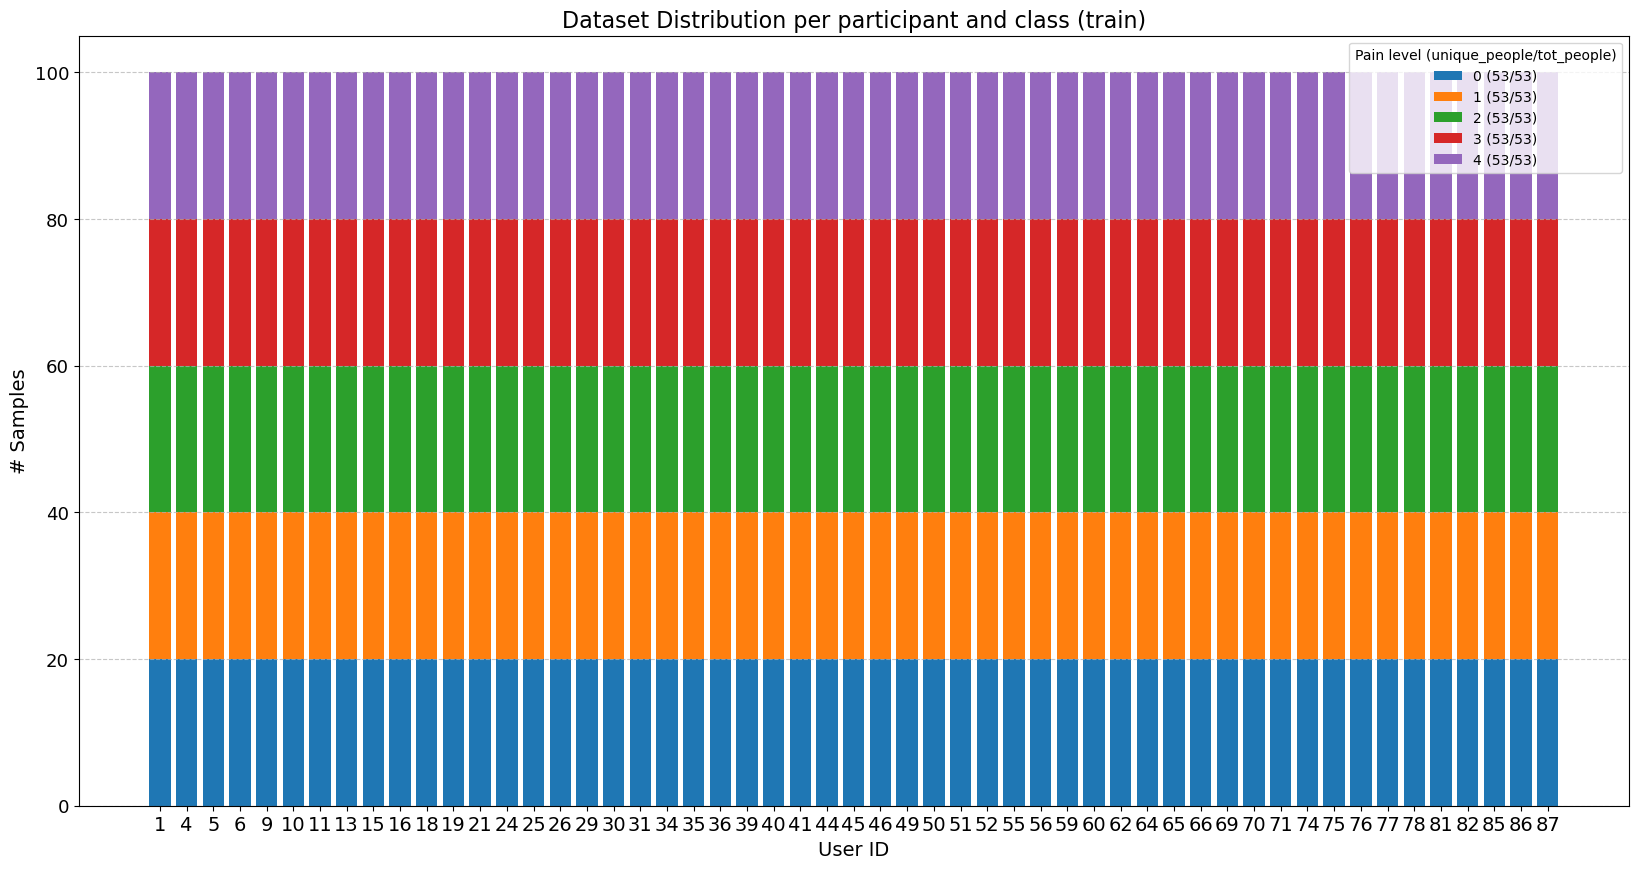

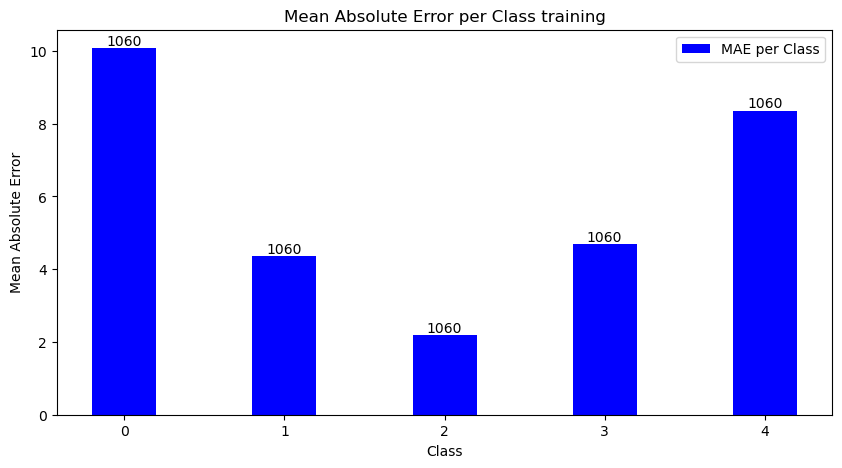

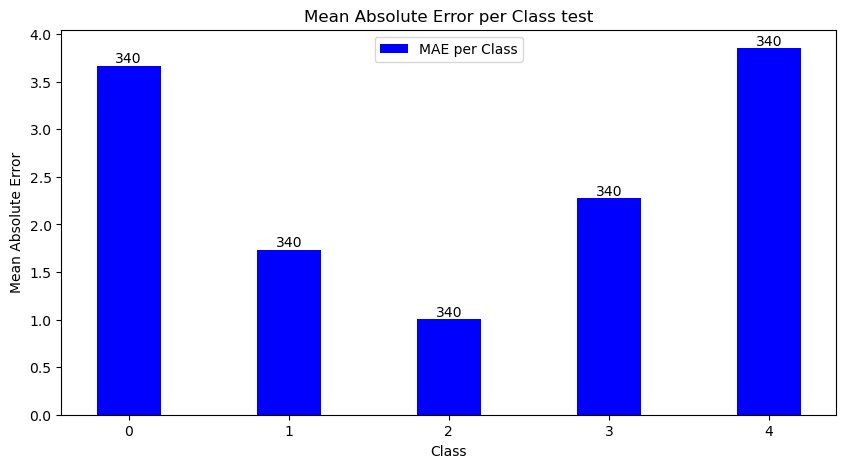

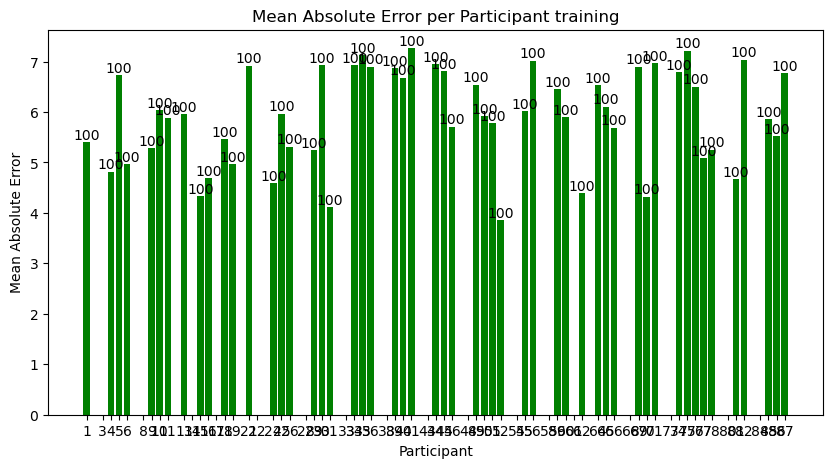

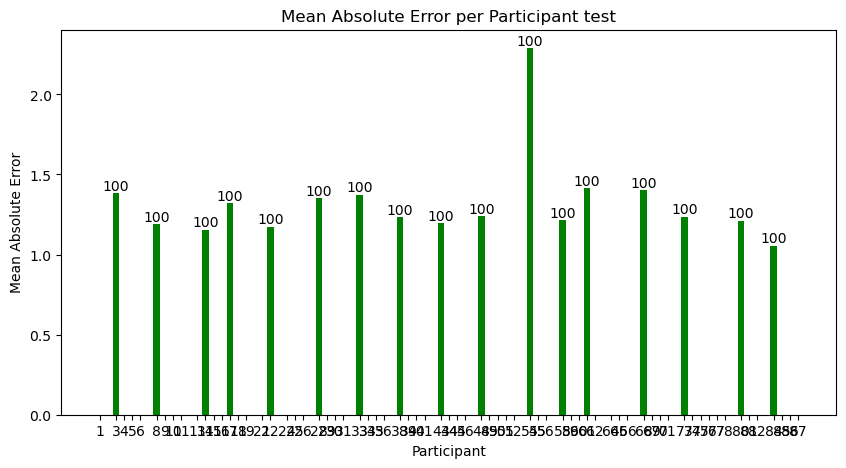

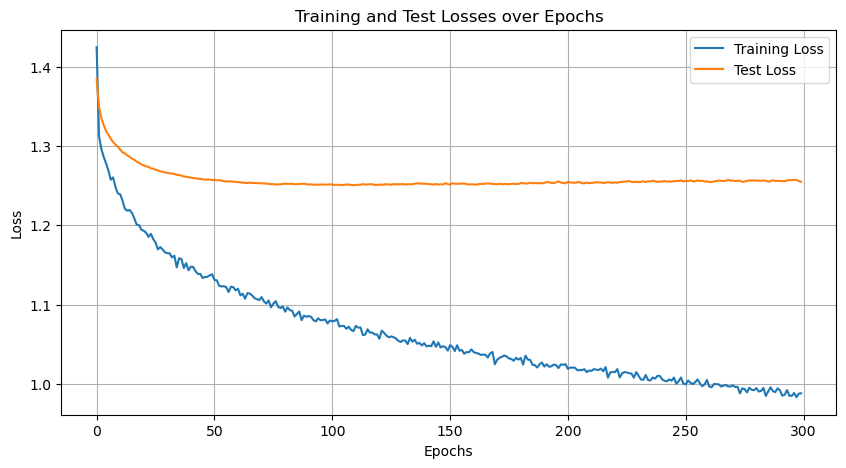

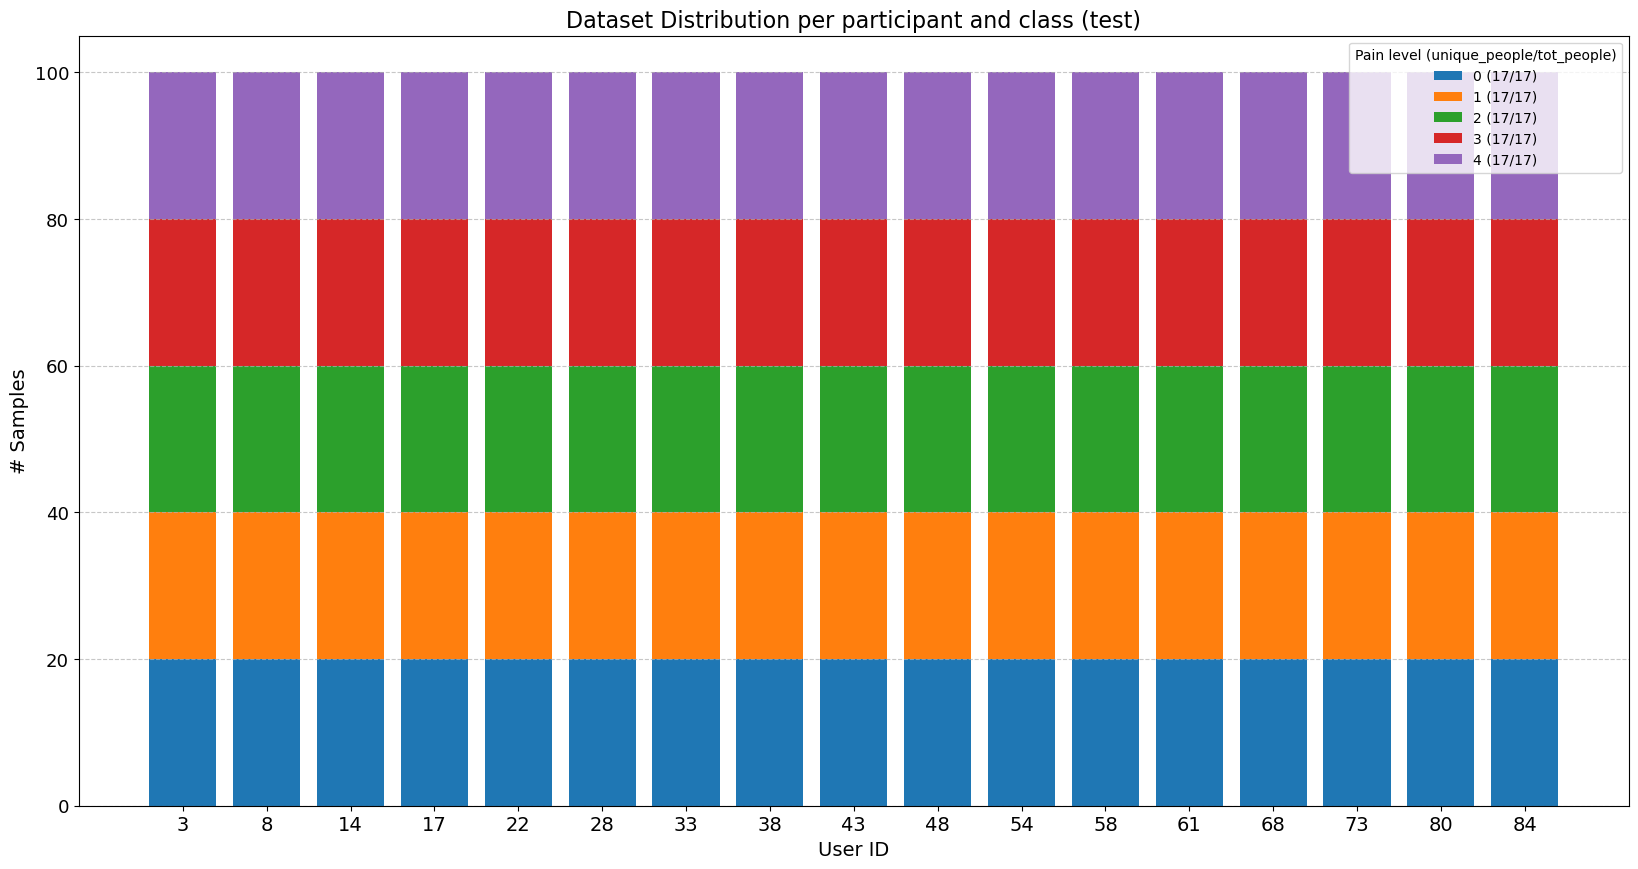

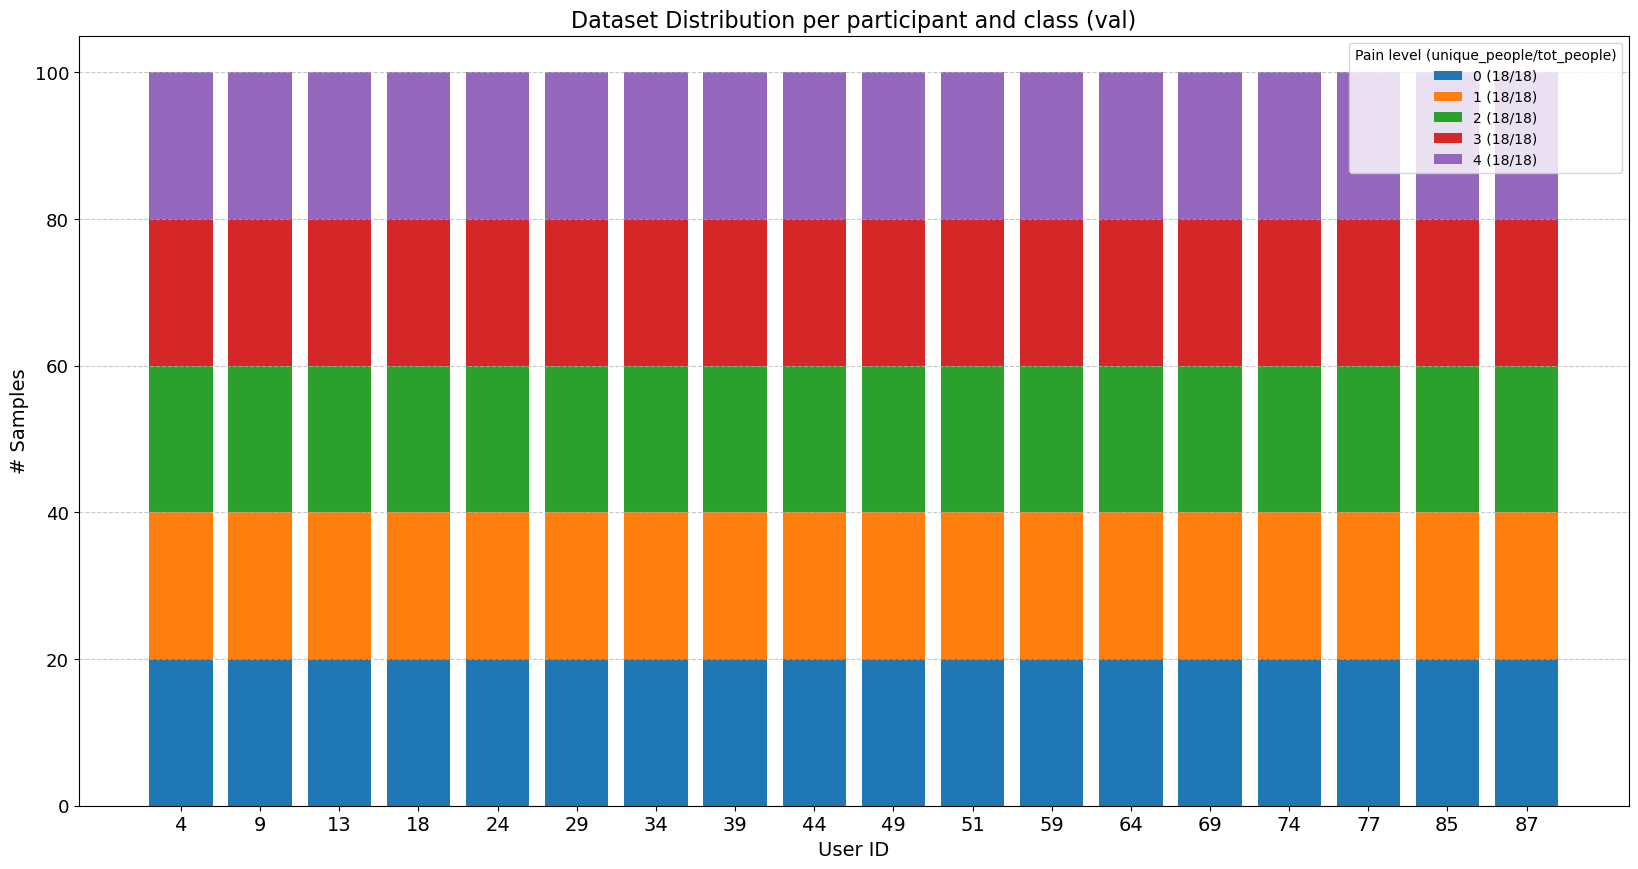

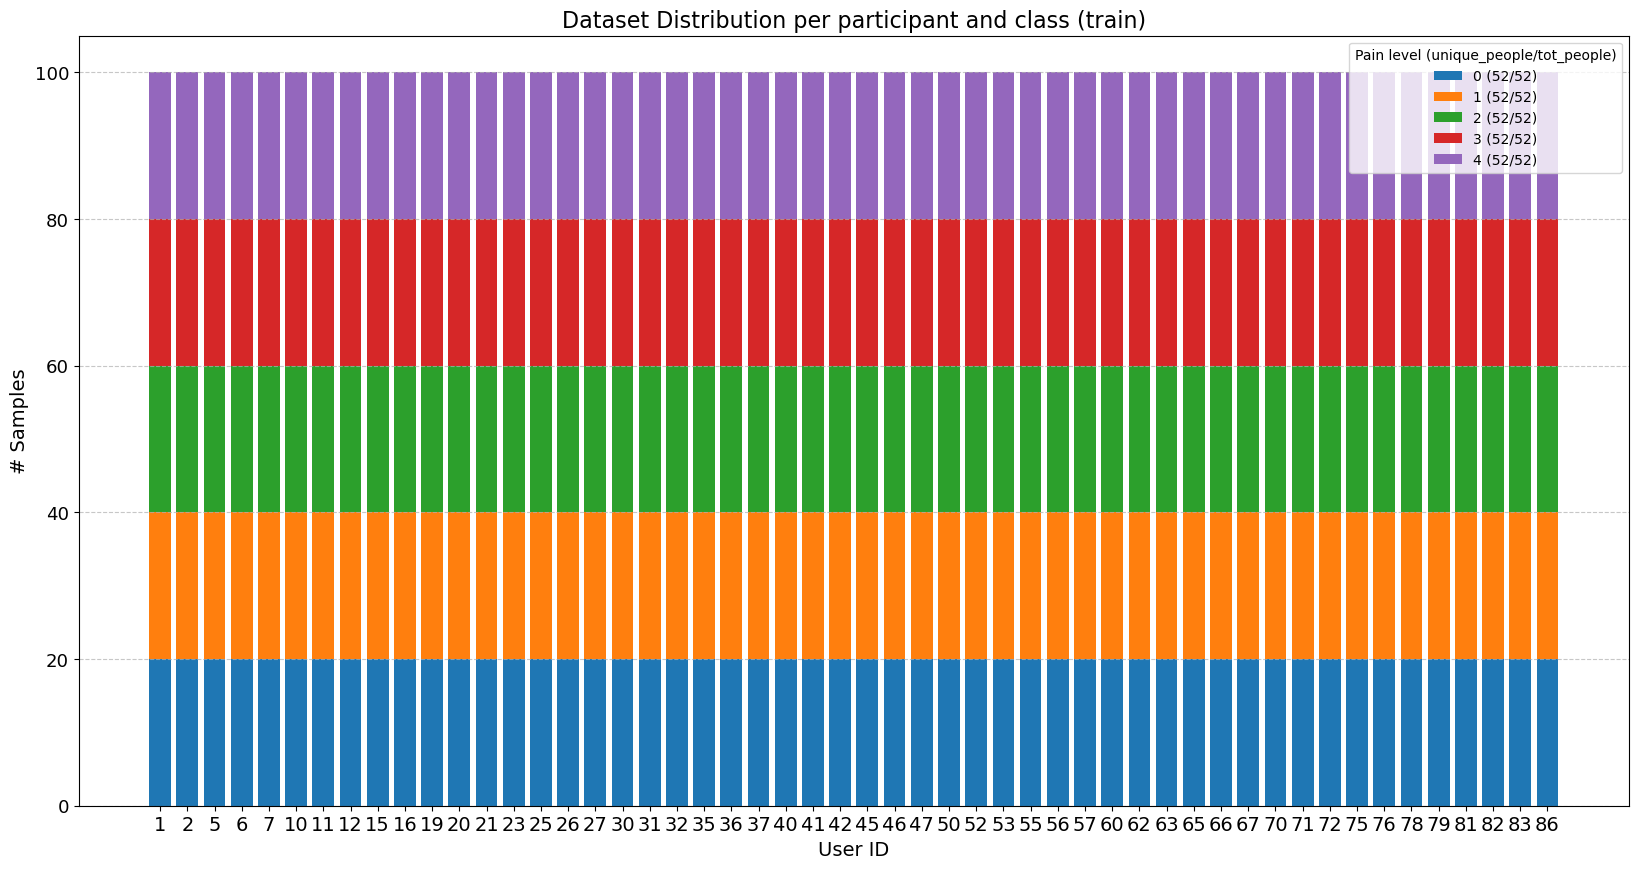

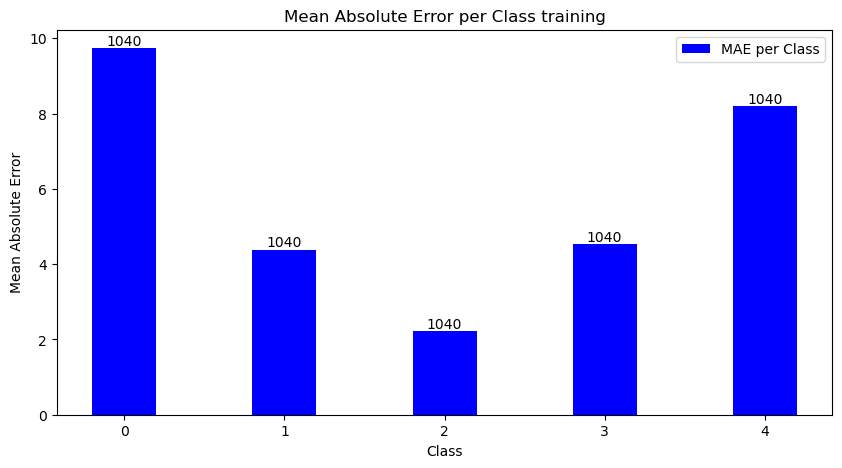

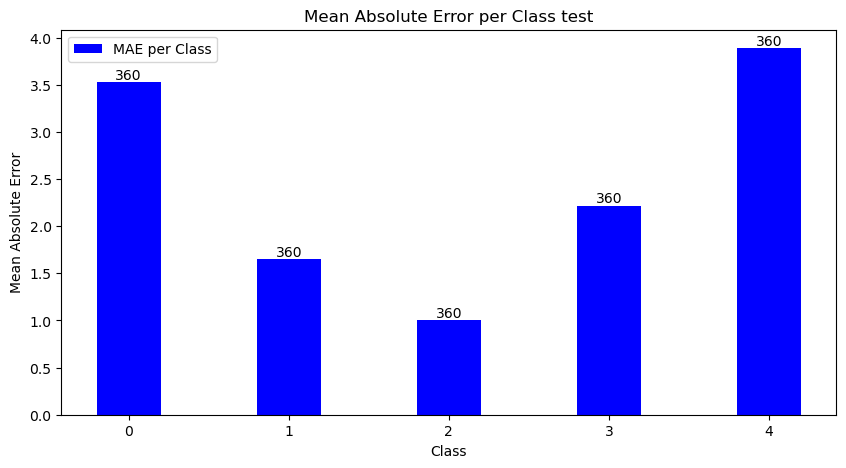

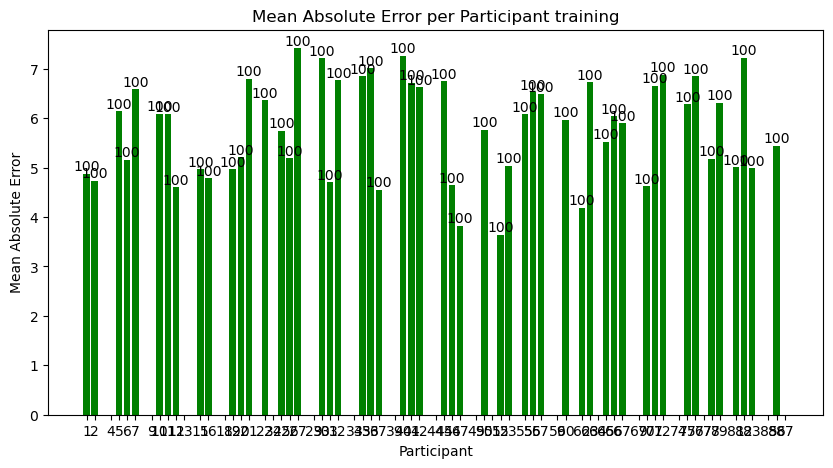

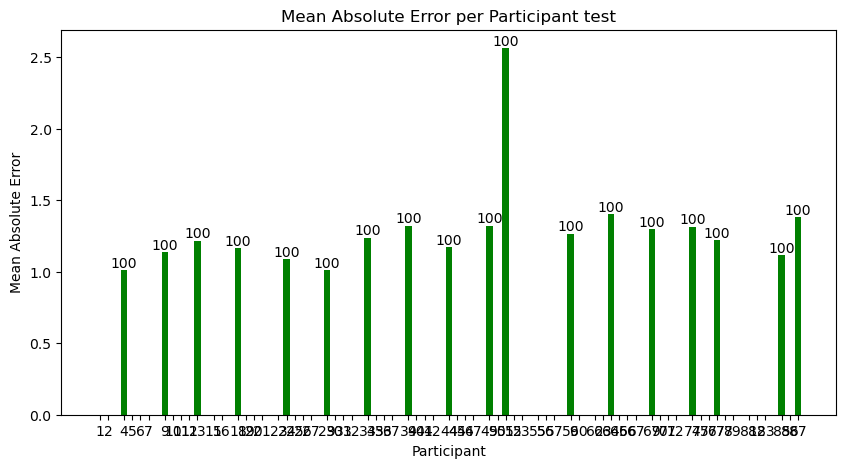

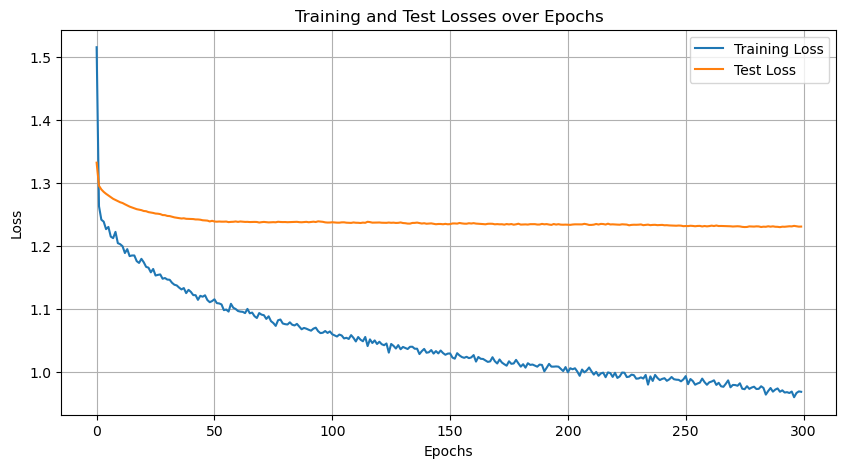

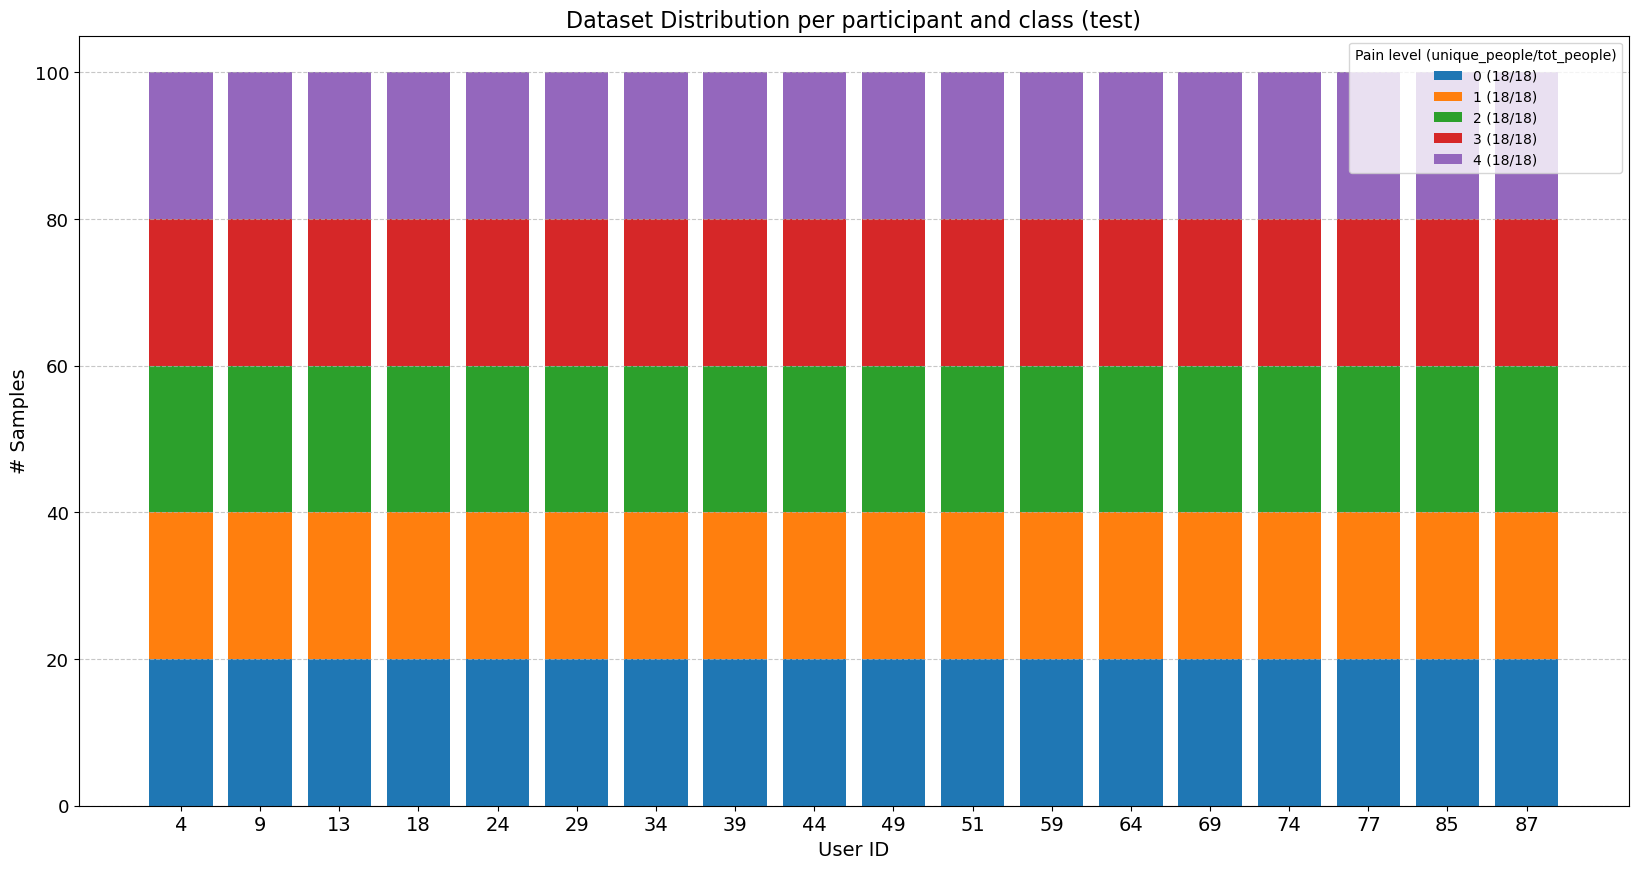

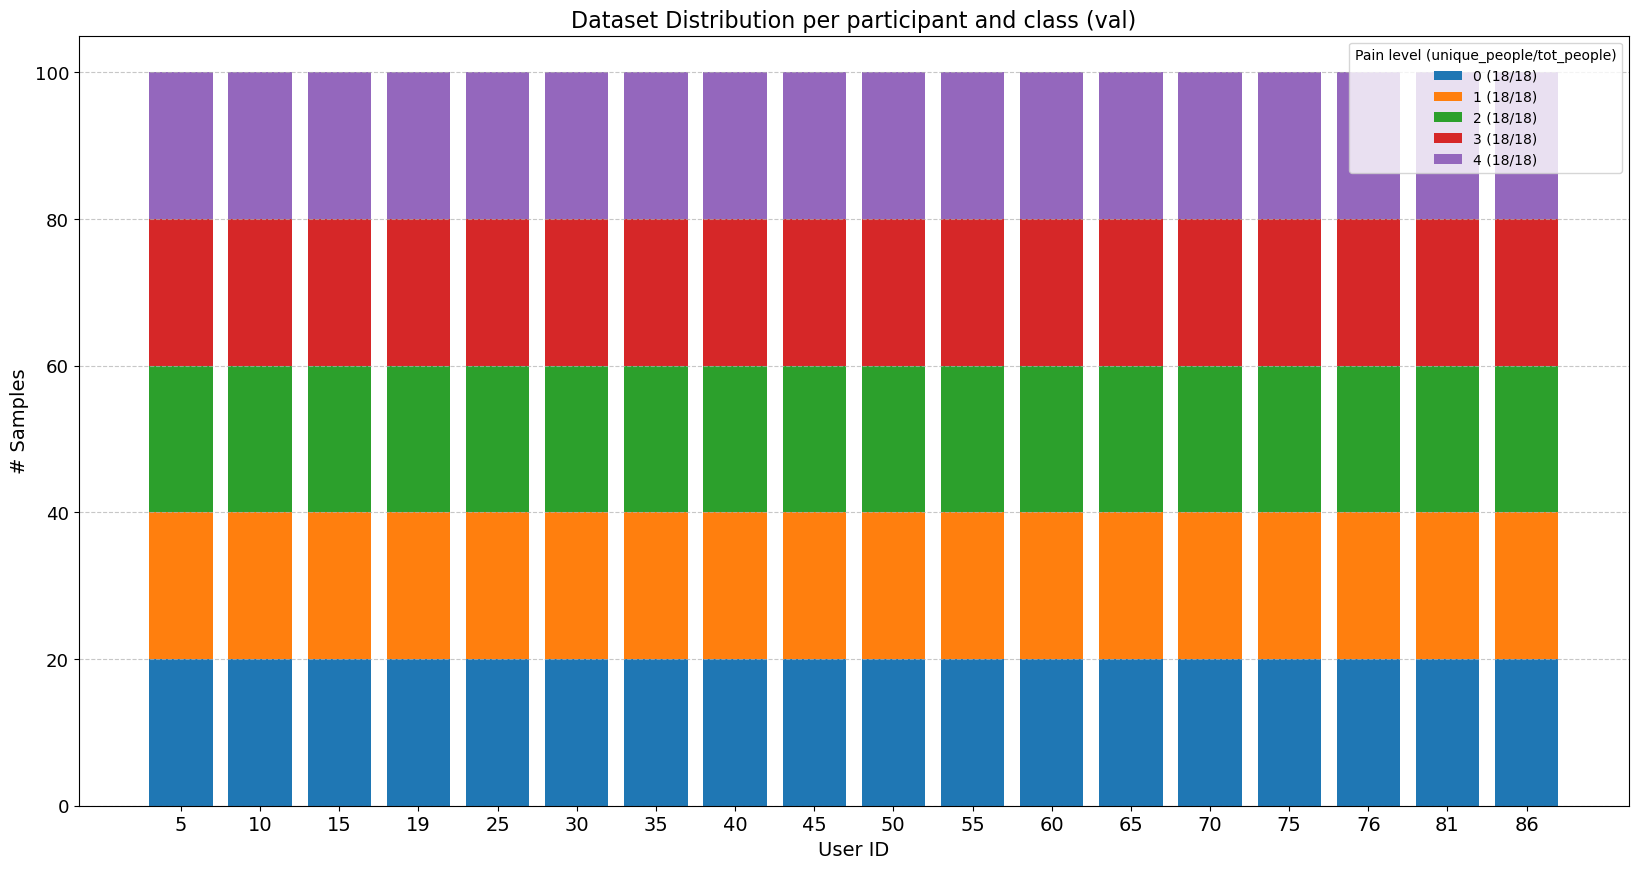

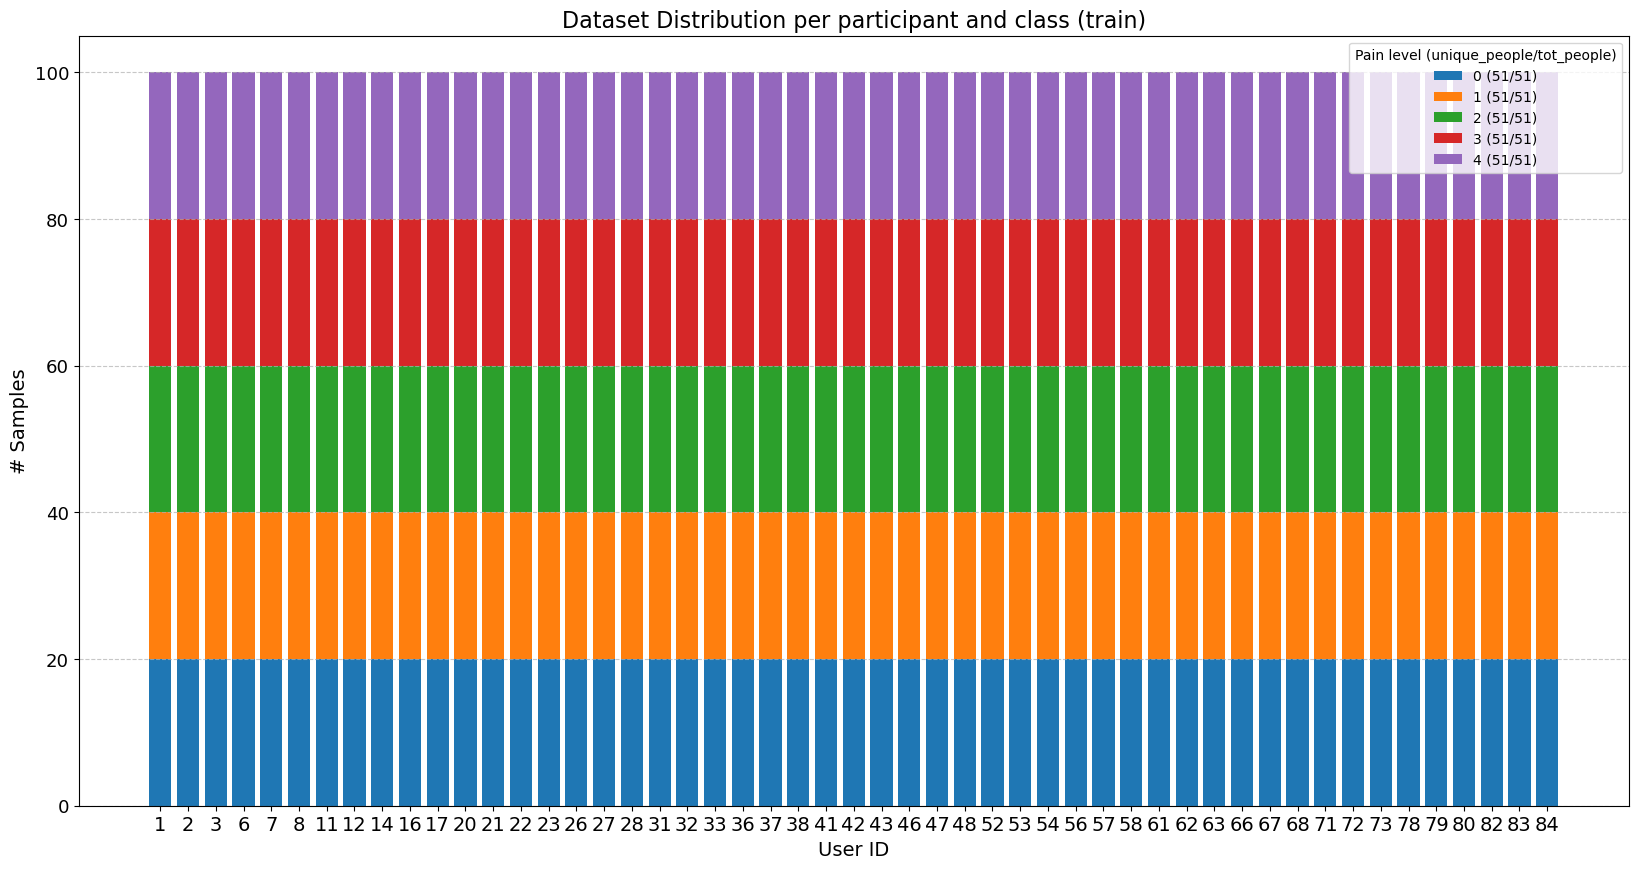

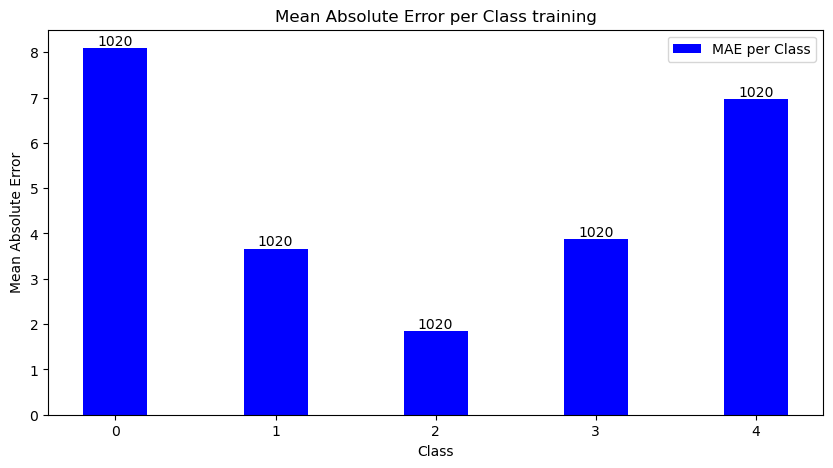

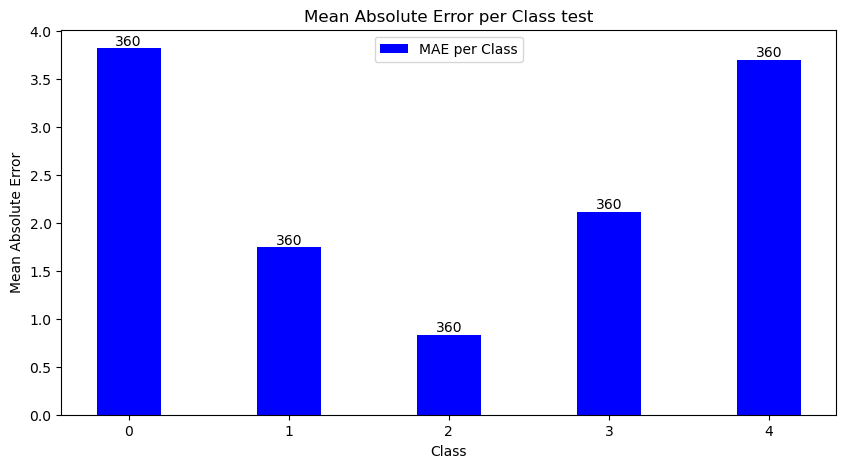

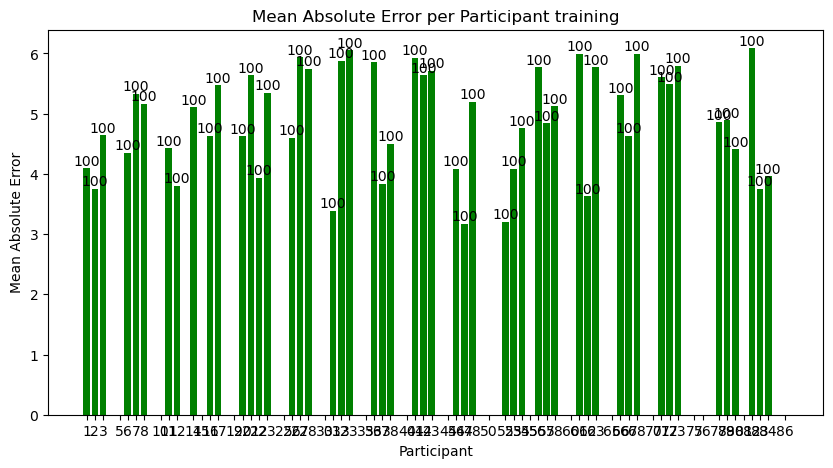

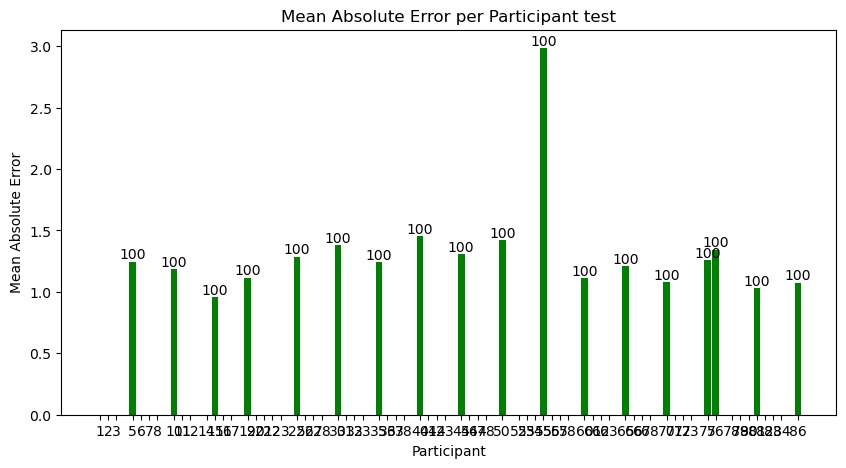

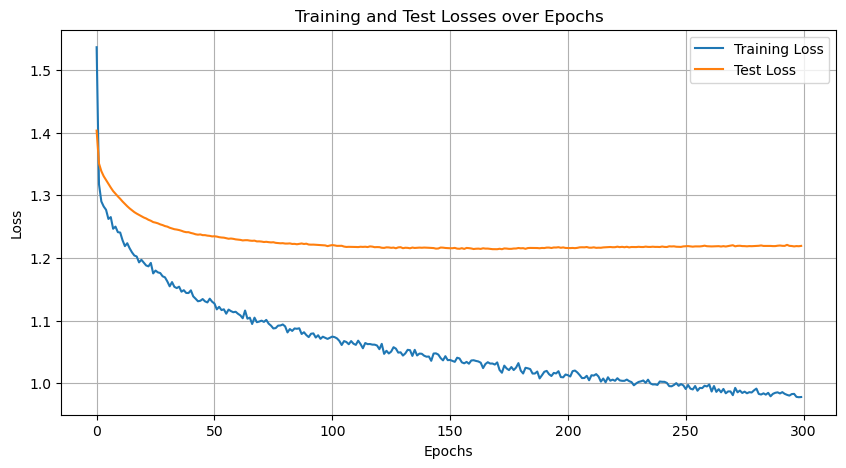

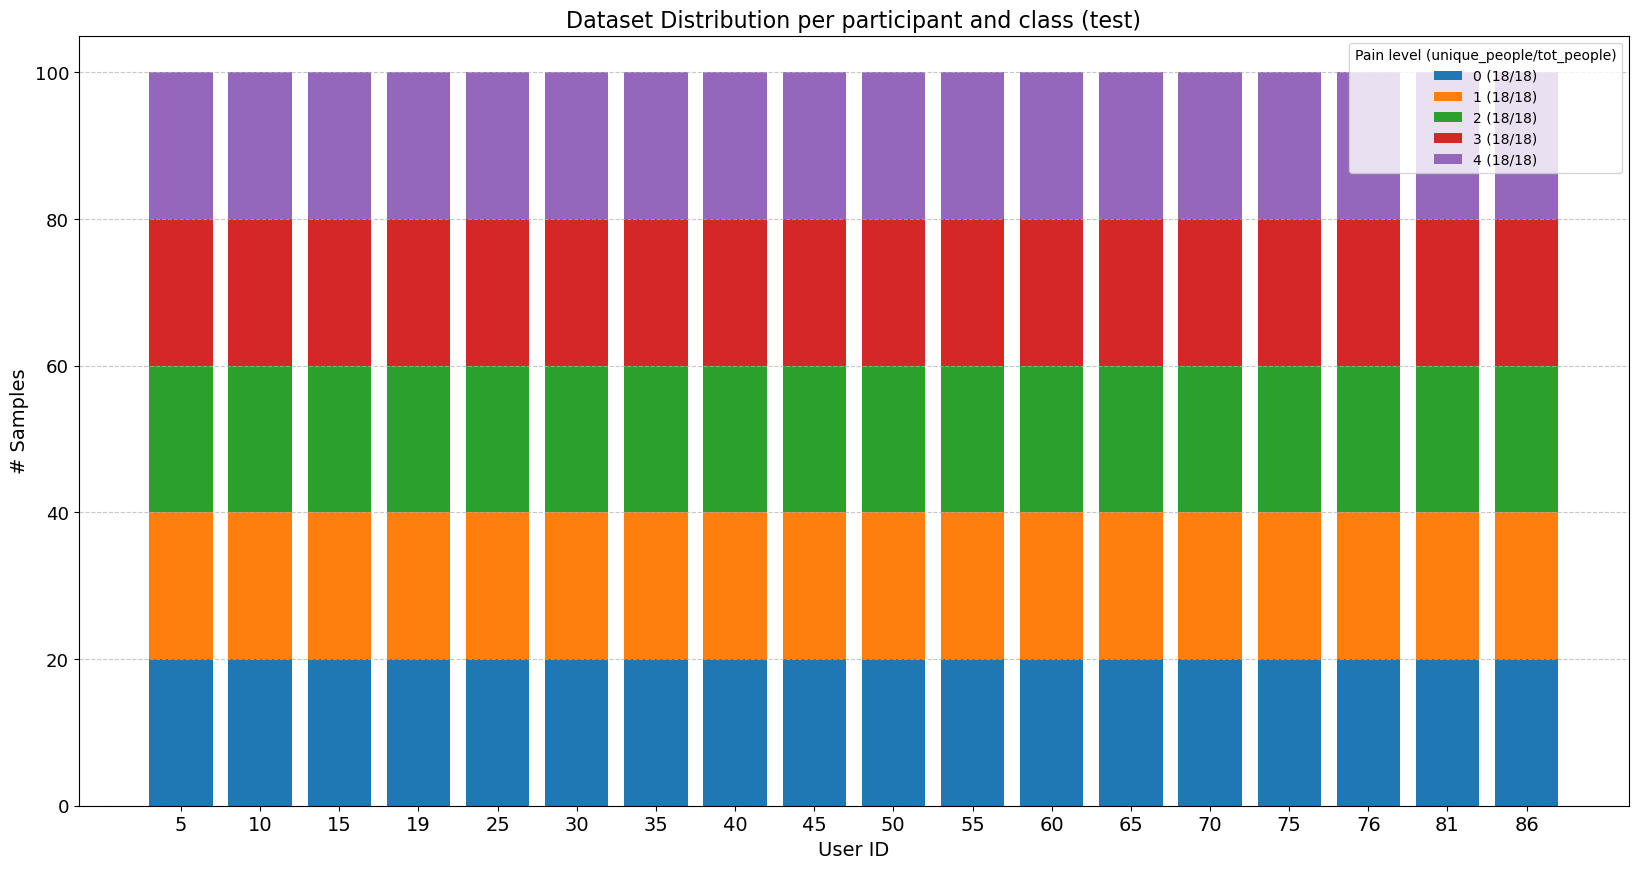

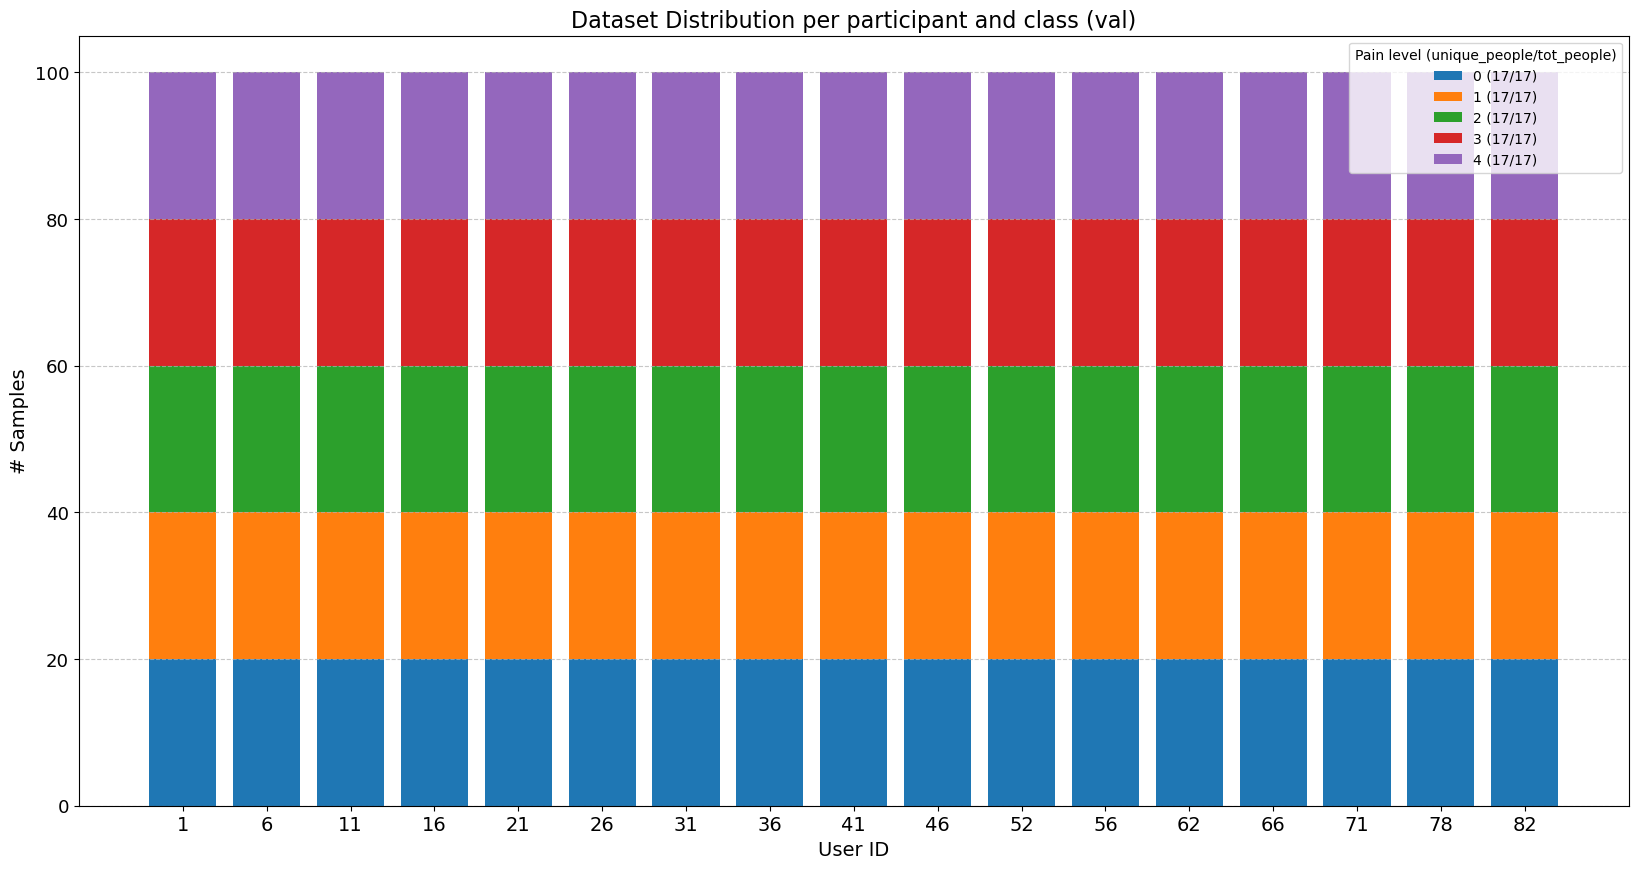

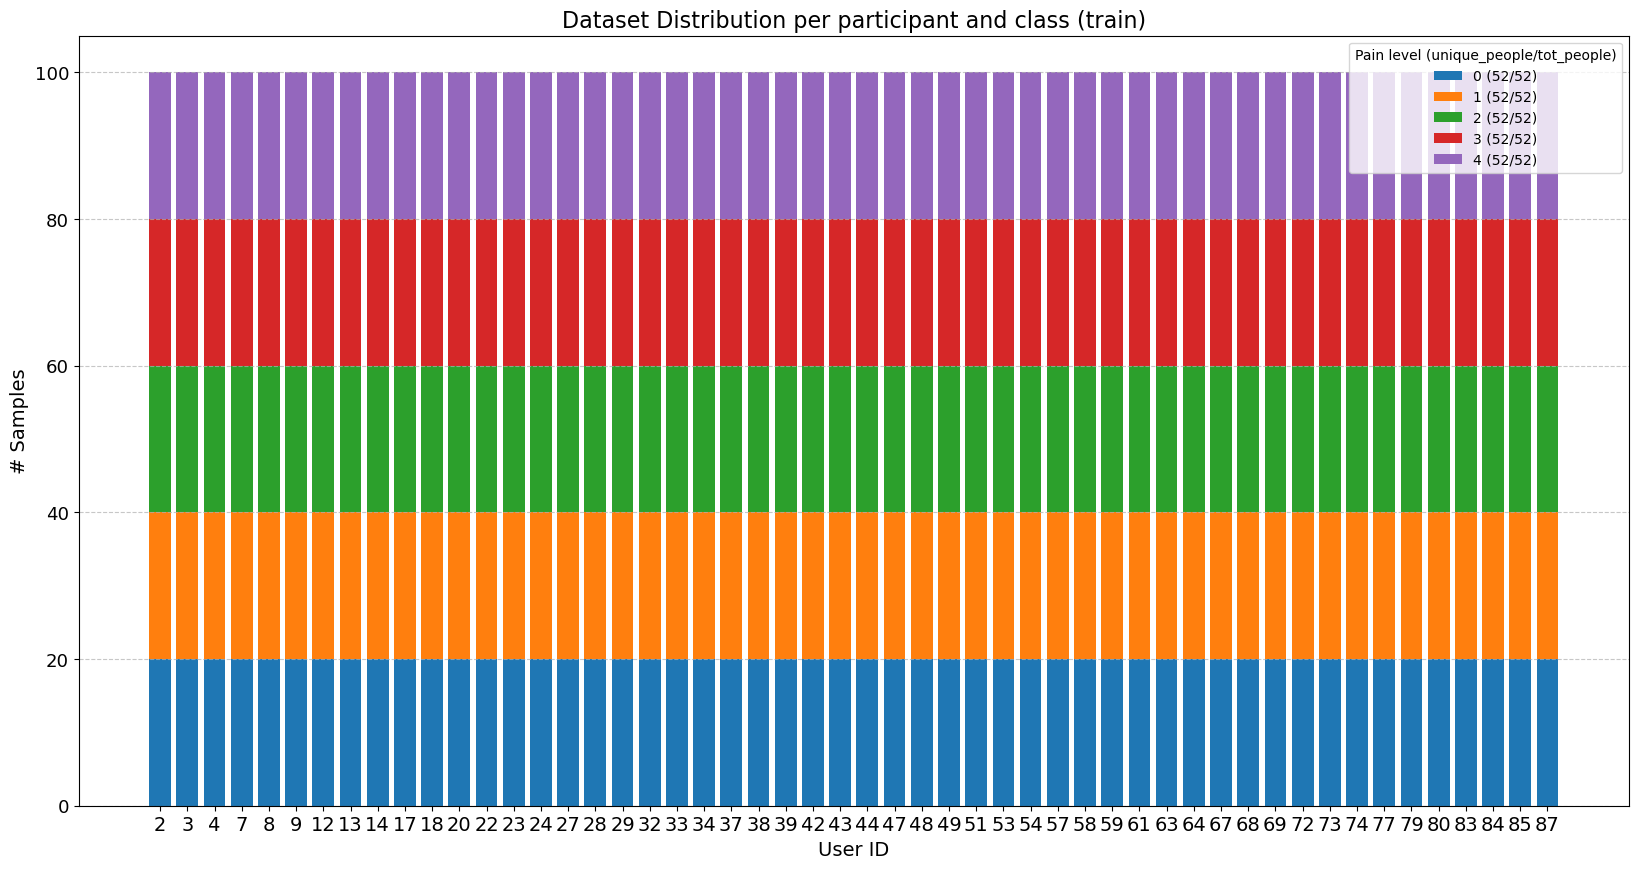

In [ ]:
%load_ext autoreload
%autoreload 2
from custom.helper import CLIPS_REDUCTION,EMBEDDING_REDUCTION,MODEL_TYPE,SAMPLE_FRAME_STRATEGY, HEAD
import os
from custom.model import Model_Advanced
from transformers import AutoImageProcessor
from custom.head import HeadSVR, HeadGRU
import time
import torch.nn as nn
import torch.optim as optim
import custom.scripts as scripts

model_type = MODEL_TYPE.VIDEOMAE_v2_S
pooling_embedding_reduction = EMBEDDING_REDUCTION.MEAN_SPATIAL
pooling_clips_reduction = CLIPS_REDUCTION.NONE
sample_frame_strategy = SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW
# path_dict ={
#   'all' : os.path.join('partA','starting_point','samples.csv'),
  # 'train' : os.path.join('partA','starting_point','train_21.csv'),
  # 'val' : os.path.join('partA','starting_point','val_26.csv'),
  # 'test' : os.path.join('partA','starting_point','test_5.csv')
# }
path_dataset = os.path.join('partA','video','video')  
path_cvs_dataset = os.path.join('partA','starting_point','samples.csv')
head = HEAD.GRU
# if head == 'GRU':
params = {
  'hidden_size': 1024,
  'num_layers': 1,
  'dropout': 0.0,
  'input_size': 768 * 8 # can be 384  (small), 768  (base), 1408  (large) [temporal_dim considered as input sequence for GRU]
                    # can be 384*8(small), 768*8(base), 1408*8(large) [temporal_dim considered feature in GRU] 
}

preprocess = AutoImageProcessor.from_pretrained(os.path.join("local_model_directory","preprocessor_config.json"))
stride_window_in_video = 16
model_advanced = scripts.run_train_test(model_type=model_type, 
                      pooling_embedding_reduction=pooling_embedding_reduction, 
                      pooling_clips_reduction=pooling_clips_reduction, 
                      sample_frame_strategy=sample_frame_strategy, 
                      path_csv_dataset=path_cvs_dataset, 
                      path_video_dataset=path_dataset,
                      head=head,
                      stride_window_in_video=stride_window_in_video, 
                      head_params=params,
                      preprocess=preprocess,
                      k_fold = 5,
                      epochs = 300,
                      train_size=0.8,
                      test_size=0.1,
                      val_size=0.1,
                      batch_size_training=1024,
                      batch_size_feat_extraction=8,  
                      criterion = nn.L1Loss(),
                      optimizer_fn = optim.SGD,
                      lr = 0.0001,
                      random_state_split_dataset=42,
                      only_train=False,
                      is_save_features_extracted=False, 
                      is_validation=True,
                      is_plot_dataset_distribution=True,
                      is_plot_loss=True,
                      is_plot_tsne_backbone_feats=True,
                      is_plot_tsne_head_pred=True,
                      is_plot_tsne_gru_feats=True,
                      is_create_video_prediction=True,
                      is_create_video_prediction_per_video=True,
                      is_round_output_loss=False,
                      is_shuffle_training_batch=True,
                      is_shuffle_video_chunks=False,
                      is_download_if_unavailable=False
                      )

In [ ]:
%autoreload 2
import custom.scripts as scripts

model_advanced.dataset.stride_window = 40
scripts.predict_per_video(
    path_csv='partA/starting_point/samples.csv',
    sample_ids=[10,35],
    model_advanced=model_advanced,
    root_folder_path='history_run/VIDEOMAE_v2_B_MEAN_SPATIAL_NONE_SLIDING_WINDOW_GRU_1733007378/train_GRU/video',
)

AttributeError: 'dict' object has no attribute 'dataset'

In [ ]:
import os

def set_working_directory():
  target_dir = 'PainAssessmentVideo'
  current_dir = os.getcwd()
  if os.path.split(current_dir)[-1] != target_dir:
    while os.path.split(current_dir)[-1] != target_dir:
      current_dir = os.path.dirname(current_dir)
      if current_dir == os.path.dirname(current_dir):  # reached the root directory
        raise FileNotFoundError(f"{target_dir} not found in the directory tree. Please set PainAssessmentVideo as current working directory.")
    os.chdir(current_dir)
  print(f"Current working directory set to: {os.getcwd()}")

def create_folder(path):
  if not os.path.exists(path):
    os.makedirs(path)
    print(f'Folder created: {path}')
  else:
    print(f'Folder already exists: {path}')                                                                                       